#### Imports

In [433]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
import pickle
import dill
import os 
import glob

from scripts import data_fetching as df
from scripts import data_preprocessing as dp
from scripts import feature_engineering as fe
from scripts import model_training as mt
from scripts import visuals as vs

importlib.reload(df)
importlib.reload(dp)
importlib.reload(fe)
importlib.reload(mt)
importlib.reload(vs)

<module 'scripts.visuals' from '/Users/vasilisvc6/Documents/Le grand cormoran project/scripts/visuals.py'>

In [2]:
pd.set_option('display.max_rows', 20)

## Data Collection

### Initial Fetching - Preprocessing
**This section includes the initial data fetching and data preparation.**

#### Date range

In [260]:
start_date = '2023-10-01'
end_date = '2024-12-01'

#### Local holidays in QC
**Using the `calendarific` API we fetch all the holidays for the corresponding year in Quebec.**

In [38]:
holidays = df.local_holidays_fetch(start_date=start_date, end_date=end_date)

In [221]:
holidays.to_csv('data/holidays.csv')

In [39]:
holidays['Name'].unique()

array(['Feast of St Francis of Assisi', 'Hoshana Rabbah',
       'Shemini Atzeret', 'Simchat Torah', 'Thanksgiving Day',
       'Halloween', "All Saints' Day", "All Souls' Day",
       'Daylight Saving Time ends', 'National Aboriginal Veterans Day',
       'Remembrance Day', 'Diwali/Deepavali', 'First Sunday of Advent',
       'Feast of the Immaculate Conception', 'First Day of Hanukkah',
       'Anniversary of the Statute of Westminster',
       'Last day of Hanukkah', 'December Solstice', 'Christmas Eve',
       'Christmas Day', 'Kwanzaa (first day)', "New Year's Eve",
       "New Year's Day", 'Day After New Year’s Day', 'Epiphany',
       'Orthodox Christmas Day', 'Orthodox New Year',
       "Tu B'Shevat (Arbor Day)", 'Groundhog Day', "Isra and Mi'raj",
       'Lunar New Year', 'Carnival / Shrove Tuesday / Pancake Day',
       'Ash Wednesday', "Valentine's Day", 'National Flag of Canada Day',
       "St David's Day", 'Daylight Saving Time starts', 'Ramadan Start',
       'Commonweal

Let's create a csv file for the holidays so we don't spend all of our available API requests.

In [261]:
holidays = pd.read_csv('data/holidays.csv')

In [262]:
holidays.set_index('Date', inplace=True)

In [263]:
holidays

Name
Date                                                 
2023-10-04              Feast of St Francis of Assisi
2023-10-06                             Hoshana Rabbah
2023-10-07                            Shemini Atzeret
2023-10-08                              Simchat Torah
2023-10-09                           Thanksgiving Day
...                                               ...
2024-08-15                         Assumption of Mary
2024-09-02                                 Labour Day
2024-09-16                     Milad un Nabi (Mawlid)
2024-09-22                          September Equinox
2024-09-30  National Day for Truth and Reconciliation

[83 rows x 1 columns]

#### Daily sales
**These are the daily total sales**

In [264]:
daily_sales = df.merge_all_sales('data/Sales')

In [265]:
daily_sales

Net Sales
2023-10-01     852.98
2023-10-02     585.47
2023-10-03     504.45
2023-10-04     402.85
2023-10-05     413.62
...               ...
2024-11-26     808.26
2024-11-27     715.61
2024-11-28     966.54
2024-11-29    1130.49
2024-11-30    1624.37

[427 rows x 1 columns]

#### Daily item sales
**We are parsing the daily sales per item from the csv files that we exported from the Clover POS system.**

In [266]:
months = ['October 2023', 'November 2023', 'December 2023', 'January 2024', 'February 2024', 'March 2024', 
          'April 2024', 'May 2024', 'June 2024', 'July 2024', 'August 2024', 'September 2024', 'October 2024', 'November 2024']

df_list = [df.merge_all_sales(f'data/Item Sales/{month}') for month in months]

data_item_sales = pd.concat(df_list)
data_item_sales

Category Name                     Name  Net Sales  Sold  \
0    Coffee Hot - Café Chaud                    Latte     105.00    23   
0    Coffee Hot - Café Chaud                    Latte     116.05    25   
0    Coffee Hot - Café Chaud                    Latte      40.80     9   
0    Coffee Hot - Café Chaud                    Latte      85.55    19   
0    Coffee Hot - Café Chaud                    Latte      80.00    18   
..                       ...                      ...        ...   ...   
37             Uncategorized     Article personnalisé       2.00     2   
38  Coffee Cold - Café Froid  Freddo Latte Citrouille       6.85     1   
38             Uncategorized     Article personnalisé       3.00     2   
39             Uncategorized     Transaction manuelle     -13.23     0   
39  Coffee Cold - Café Froid           Iced Americano       4.20     1   

         date  
0  2023-10-26  
0  2023-10-06  
0  2023-10-05  
0  2023-10-02  
0  2023-10-12  
..        ...  
37 2024-11-24  
38 2024-11-03  
38 2024-11-16  
39 2024-11-16  
39 2024-11-03  

[14365 rows x 5 columns]

In [267]:
dates = pd.date_range(start='2023-10-01', end='2024-11-30', freq='D')

**These are dates that the cafe was closed**

In [268]:
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex(['2023-12-25', '2023-12-26', '2024-01-01', '2024-01-02',
               '2024-05-05', '2024-10-22'],
              dtype='datetime64[ns]', freq=None)

In [269]:
# Create a DataFrame with missing dates and fill columns with 0
missing_data = pd.DataFrame({
    'Category Name': [''] * len(missing_dates),
    'Name': [''] * len(missing_dates),
    'Net Sales': [0.0] * len(missing_dates),
    'Sold': [0] * len(missing_dates),
    'date': missing_dates,
    'closed': [1] * len(missing_dates)
})

# Add 'closed' column to data_item_sales and set default value to 0
data_item_sales['closed'] = 0

# Concatenate the missing_data DataFrame with data_item_sales
data_item_sales = pd.concat([data_item_sales, missing_data], ignore_index=True)

# Sort the DataFrame by date
data_item_sales = data_item_sales.sort_values(by='date').reset_index(drop=True)

data_item_sales

Category Name                Name  Net Sales  Sold  \
0         Coffee Hot - Café Chaud        Batch Filtre      15.50     5   
1                   Uncategorized  Mosaic au Chocolat      27.00     9   
2                   Uncategorized    Gâteau au citron      23.10     7   
3         Coffee Hot - Café Chaud          Long Black       9.90     3   
4         Coffee Hot - Café Chaud         Mocha Latte      15.70     3   
...                           ...                 ...        ...   ...   
14366     Coffee Hot - Café Chaud             Cortado      57.40    14   
14367  Sans Café - Without Coffee          Chai Latte      56.30    11   
14368                Menu Spécial        Chia Pudding       9.00     1   
14369                Menu Spécial        Méditerranée      60.00     5   
14370     Coffee Hot - Café Chaud    Latte Citrouille      30.95     5   

            date  closed  
0     2023-10-01       0  
1     2023-10-01       0  
2     2023-10-01       0  
3     2023-10-01       0  
4     2023-10-01       0  
...          ...     ...  
14366 2024-11-30       0  
14367 2024-11-30       0  
14368 2024-11-30       0  
14369 2024-11-30       0  
14370 2024-11-30       0  

[14371 rows x 6 columns]

In [270]:
print(len(dates))
print(len(data_item_sales['date'].unique()))

427
427


#### Macroeconomic indicators
**Using the `FRED` API we are fetching the CPI, Unemployment Rate and Bond Yield rate.**

In [271]:
cpi, unemployment, bond_yields = df.macroeconomic_fetch_fred(start_date=start_date, end_date=end_date)

In [272]:
cpi

CPI
2023-10-01  4.882717
2023-11-01  4.691251
2023-12-01  4.557667
2024-01-01  4.601332
2024-02-01  4.400073
2024-03-01  4.502758
2024-04-01  4.403618
2024-05-01  4.300148
2024-06-01  4.234733
2024-07-01  4.179707
2024-08-01  4.112096
2024-09-01  4.012724
2024-10-01  3.963395
2024-11-01  3.876177
2024-12-01  3.746553

In [273]:
unemployment

Unemployment Rate
2023-10-01                5.7
2023-11-01                5.7
2023-12-01                5.8
2024-01-01                5.7
2024-02-01                5.9
2024-03-01                6.1
2024-04-01                6.2
2024-05-01                6.3
2024-06-01                6.4
2024-07-01                6.4
2024-08-01                6.7
2024-09-01                6.6
2024-10-01                6.6
2024-11-01                6.9
2024-12-01                6.7

In [274]:
bond_yields

Bond Yields
2023-10-01     4.062000
2023-11-01     3.710952
2023-12-01     3.234211
2024-01-01     3.346364
2024-02-01     3.504000
2024-03-01     3.444000
2024-04-01     3.695909
2024-05-01     3.641818
2024-06-01     3.391500
2024-07-01     3.407727
2024-08-01     3.071500
2024-09-01     2.944444
2024-10-01     3.186364
2024-11-01     3.278500
2024-12-01     3.161500

#### Historical Weather Data
**Using the `meteostat` API we are fetching daily weather data for the coordinates of Montreal.**

In [275]:
from datetime import datetime
weather = df.fetch_the_weather(start_date, end_date)

In [276]:
weather = weather[:-1]

In [277]:
weather

tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2023-10-01  18.4  13.0  25.0   0.0   NaN  344.0   8.5   NaN  1023.7   NaN
2023-10-02  17.5  11.0  23.0   0.0   NaN  295.0   7.2   NaN  1023.0   NaN
2023-10-03  21.1  17.0  27.0   0.0   NaN  227.0  15.2   NaN  1018.7   NaN
2023-10-04  22.5  15.7  29.0   0.0   NaN  211.0   9.5   NaN  1020.3   NaN
2023-10-05  22.8  18.6  28.0   0.0   NaN  156.0  13.0   NaN  1018.0   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-11-26   1.4  -2.0   4.0  10.0   NaN   40.0  11.9  27.8  1008.8   NaN
2024-11-27   3.7   1.7   5.0   0.1   NaN  249.0  26.3  33.3  1010.5   NaN
2024-11-28   2.0   1.0   3.1   4.3   NaN  146.0  13.0  38.9  1007.9   NaN
2024-11-29   0.7  -2.0   3.1   0.0   NaN  244.0  16.2  29.6  1006.6   NaN
2024-11-30   0.4  -1.0   2.0   1.0   NaN  251.0  22.4  37.0  1008.3   NaN

[427 rows x 10 columns]

### Pre-processing & Feature Engineering
**In this section we are performing basic preprocessing such as converting the macroindicators to daily frequency and handle missing values in the weather data. We also create certain features, such as `holiday_type_2` which is a flag indicating whether a day is a major holiday. Furthermore, we create time-based features such as `quarter` of the year, `day of week`.**

#### Macroeconomic indicators (daily)

##### CPI - daily

The following cell resamples the monthly CPI data to daily frequency by forward filling

In [278]:
cpi_daily = dp.daily_resample(cpi, start_date=start_date, end_date=end_date)
cpi_daily = cpi_daily[:-1]
cpi_daily

CPI
2023-10-01  4.882717
2023-10-02  4.876541
2023-10-03  4.870364
2023-10-04  4.864188
2023-10-05  4.858012
...              ...
2024-11-26  3.768157
2024-11-27  3.763836
2024-11-28  3.759515
2024-11-29  3.755195
2024-11-30  3.750874

[427 rows x 1 columns]

##### Unemployment - daily

The following cell resamples the monthly unemployment rate data to daily frequency by forward filling

In [279]:
unemployment_daily = dp.daily_resample(unemployment, start_date=start_date, end_date=end_date)
unemployment_daily = unemployment_daily[:-1]
unemployment_daily

Unemployment Rate
2023-10-01           5.700000
2023-10-02           5.700000
2023-10-03           5.700000
2023-10-04           5.700000
2023-10-05           5.700000
...                       ...
2024-11-26           6.733333
2024-11-27           6.726667
2024-11-28           6.720000
2024-11-29           6.713333
2024-11-30           6.706667

[427 rows x 1 columns]

##### Bond Yields - daily

The following cell resamples the monthly bond yields rate data to daily frequency by forward filling

In [280]:
bond_yields_daily = dp.daily_resample(bond_yields, start_date=start_date, end_date=end_date)
bond_yields_daily = bond_yields_daily[:-1]
bond_yields_daily

Bond Yields
2023-10-01     4.062000
2023-10-02     4.050676
2023-10-03     4.039352
2023-10-04     4.028028
2023-10-05     4.016704
...                 ...
2024-11-26     3.181000
2024-11-27     3.177100
2024-11-28     3.173200
2024-11-29     3.169300
2024-11-30     3.165400

[427 rows x 1 columns]

##### Joined macroecomomic indicators

In [281]:
macroeconomic = pd.concat([cpi_daily, unemployment_daily, bond_yields_daily], axis=1)
macroeconomic

CPI  Unemployment Rate  Bond Yields
2023-10-01  4.882717           5.700000     4.062000
2023-10-02  4.876541           5.700000     4.050676
2023-10-03  4.870364           5.700000     4.039352
2023-10-04  4.864188           5.700000     4.028028
2023-10-05  4.858012           5.700000     4.016704
...              ...                ...          ...
2024-11-26  3.768157           6.733333     3.181000
2024-11-27  3.763836           6.726667     3.177100
2024-11-28  3.759515           6.720000     3.173200
2024-11-29  3.755195           6.713333     3.169300
2024-11-30  3.750874           6.706667     3.165400

[427 rows x 3 columns]

In [282]:
macroeconomic.to_csv('data/macroeconomic.csv')

#### Weather - cleaned

In [283]:
weather.isna().sum()

tavg      0
tmin      0
tmax      0
prcp      8
snow    250
wdir      0
wspd      0
wpgt    342
pres      0
tsun    427
dtype: int64

In [284]:
weather_clean = dp.weather_preprocess(weather)

In [285]:
weather_clean

tavg  tmin  tmax  prcp   wdir  wspd    pres
time                                                   
2023-10-01  18.4  13.0  25.0   0.0  344.0   8.5  1023.7
2023-10-02  17.5  11.0  23.0   0.0  295.0   7.2  1023.0
2023-10-03  21.1  17.0  27.0   0.0  227.0  15.2  1018.7
2023-10-04  22.5  15.7  29.0   0.0  211.0   9.5  1020.3
2023-10-05  22.8  18.6  28.0   0.0  156.0  13.0  1018.0
...          ...   ...   ...   ...    ...   ...     ...
2024-11-26   1.4  -2.0   4.0  10.0   40.0  11.9  1008.8
2024-11-27   3.7   1.7   5.0   0.1  249.0  26.3  1010.5
2024-11-28   2.0   1.0   3.1   4.3  146.0  13.0  1007.9
2024-11-29   0.7  -2.0   3.1   0.0  244.0  16.2  1006.6
2024-11-30   0.4  -1.0   2.0   1.0  251.0  22.4  1008.3

[427 rows x 7 columns]

In [286]:
weather_clean.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
wdir    0
wspd    0
pres    0
dtype: int64

#### Local Holidays - every day

In [287]:
holiday_features  = fe.create_holiday_features(holidays, start_date=start_date, end_date=end_date)
holiday_features.value_counts()

holiday_type_2
0                 417
1                  11
Name: count, dtype: int64

In [288]:
holiday_features = holiday_features[:-1]
holiday_features

holiday_type_2
Date                      
2023-10-01               0
2023-10-02               0
2023-10-03               0
2023-10-04               0
2023-10-05               0
...                    ...
2024-11-26               0
2024-11-27               0
2024-11-28               0
2024-11-29               0
2024-11-30               0

[427 rows x 1 columns]

#### Pedestrinization (boolean)

In [289]:
pedestrinization = fe.create_pedestrianization(ped_start='2024-06-01', ped_end='2024-08-30', start_date=start_date, end_date=end_date)
pedestrinization = pedestrinization[:-1]
pedestrinization.value_counts()

is_pedestrian
0                336
1                 91
Name: count, dtype: int64

#### Time based features

In [290]:
time_features = fe.create_time_features(start_date=start_date, end_date=end_date)
time_features = time_features[:-1]
time_features['quarter'].value_counts()

quarter
4    153
3     92
1     91
2     91
Name: count, dtype: int64

## EDA (Exploratory Data Analysis) - Further processing
**This section includes data exploration and data adjustments based on results.**

**Daily item sales - EDA**

#### Categorizing and fixing errors
**We will categorize properly all products and remove products unecessary for our analysis.**

The uncategorized items are usually special request items that are not on the menu. As a result we won't examine them.

In [291]:
data_item_sales['Category Name'].unique()

array(['Coffee Hot - Café Chaud', 'Uncategorized',
       'Coffee Cold - Café Froid', 'Desserts',
       'Sans Café - Without Coffee', 'Merch', '',
       'Coffee Beans & Chocolat', 'Menu Spécial', 'Birthday Menu'],
      dtype=object)

The birthday menu was there just for the event, therefore they are considered unimpactful in the overall performance of the business

In [292]:
data_item_sales = data_item_sales[~(data_item_sales['Category Name'] == 'Birthday Menu')]

Check for items with multiple categories

In [293]:
# Check for items with multiple categories
multiple_categories = (
    data_item_sales
    .groupby('Name')['Category Name']
    .nunique()
    .reset_index()
    .query('`Category Name` > 1')
)

if len(multiple_categories) > 0:
    print("Items with multiple categories:")
    # Show the actual categories for these items
    for item in multiple_categories['Name']:
        categories = data_item_sales[data_item_sales['Name'] == item]['Category Name'].unique()
        print(f"\n{item}:")
        print(categories)
else:
    print("No items with multiple categories found")

Items with multiple categories:

Chia Pudding:
['Uncategorized' 'Menu Spécial']


In [294]:
data_item_sales.loc[data_item_sales['Name'] == 'Chia Pudding', 'Category Name'] = 'Menu Spécial'

The items that have an amount sold that's less than 10 are considered irrelevant.

In [295]:
total_amounts = data_item_sales.groupby('Name')['Sold'].sum().sort_values(ascending=False)
irelevant_items = total_amounts[total_amounts < 10].index

In [296]:
data_item_sales = data_item_sales[~data_item_sales['Name'].isin(irelevant_items)]

#### Uncategorized
**Categorizing products that don't currently fall under any group.**

We need to categorize the uncategorized items

In [297]:
def show_uncategorized_items(data_item_sales):
    print("Uncategorized items:")
    print(data_item_sales.loc[data_item_sales['Category Name'] == 'Uncategorized']['Name'].unique())

show_uncategorized_items(data_item_sales)

Uncategorized items:
['Mosaic au Chocolat' 'Gâteau au citron' 'Croissant' 'Lavande Latte'
 'Profiterole petite' 'Colorfull' 'Pain à la banane' 'Choux A La Creme'
 'Betterave Latte' 'Flash Brew - Cold Filter' 'Gateau aux pommes'
 'Dejeuner Sandwich' 'Croissant Aux Amandes' 'Article personnalisé'
 'Toast Betterave' 'Toast Avocat' 'Butterfly Latte' 'Tarte au chocolat'
 'Bostock' 'Kayana' 'Brownie' 'Tiramisu' 'Mille-feuille' 'Robinson Rivera'
 "Pain D'épices" 'Salmon Sandwich' 'Biscuit Noel' 'Brioche' 'Cruller'
 'Old Fashioned' 'Sandwich Saucisse' 'Basha Bekele Espresso'
 'Bisuit Orange' 'Gateau Noisette' 'Matcha Biscuit'
 'Proud Mary Ghost Rider' 'Strawberry Bun' 'Brioche Caux Noir'
 'Colorfull Melon' 'Colorfull Lost & Found' 'Oreo Brioche'
 'Diego Bermudez' 'Subtext Volcan Azul' 'Colorful Jelly'
 'Brioche Citron Noir' 'Colorful Melon' 'Tsoureki Brioche'
 'Tumba Duck Rabbit' 'Kanzu Rwanda' 'Biscuit Au Caramel' 'Hugo Argeda'
 'September Hernandez' 'Colorful Plum Jelly' 'September Keramo'
 

Let's deal with the coffee beans first. <br>
Colorful, September, Duck Rabbit, Traffic, Subtext, Proud Mary are some of our coffee beans suppliers. <br>
I can also see some names that refer to coffee farmers and regions.

In [298]:
# Suppliers
suppliers = ['Colorful', 'Colorfull', 'September', 'Duck Rabbit', 'Traffic', 'Subtext', 'Proud Mary']
suppliers_pattern = '|'.join(suppliers)
data_item_sales.loc[data_item_sales['Name'].str.contains(suppliers_pattern, case=False), 'Category Name'] = 'Coffee Beans & Chocolat'
# Farmers and regions
coffee_names = ['Irineo Ramirez', 'Hugo Argeda', 'Diego Bermudez', 'Kanzu Rwanda', 'Basha Bekele Espresso', 'Robinson Rivera']
data_item_sales.loc[data_item_sales['Name'].isin(coffee_names), 'Category Name'] = 'Coffee Beans & Chocolat'

In [299]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Mosaic au Chocolat' 'Gâteau au citron' 'Croissant' 'Lavande Latte'
 'Profiterole petite' 'Pain à la banane' 'Choux A La Creme'
 'Betterave Latte' 'Flash Brew - Cold Filter' 'Gateau aux pommes'
 'Dejeuner Sandwich' 'Croissant Aux Amandes' 'Article personnalisé'
 'Toast Betterave' 'Toast Avocat' 'Butterfly Latte' 'Tarte au chocolat'
 'Bostock' 'Kayana' 'Brownie' 'Tiramisu' 'Mille-feuille' "Pain D'épices"
 'Salmon Sandwich' 'Biscuit Noel' 'Brioche' 'Cruller' 'Old Fashioned'
 'Sandwich Saucisse' 'Bisuit Orange' 'Gateau Noisette' 'Matcha Biscuit'
 'Strawberry Bun' 'Brioche Caux Noir' 'Oreo Brioche' 'Brioche Citron Noir'
 'Tsoureki Brioche' 'Biscuit Au Caramel']


Now let's deal with the desserts

In [300]:
desserts = ['Biscuit', 'Brioche', 'Bun', 'Croissant', 'Gateau', 'Gâteau', 'Pain', 'Brownie', 'Chocolat', 'Tiramisu', 'Mille-feuille', 'Orange', 'Choux', 'Profiterole', 'Bostock']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(desserts), case=False), 'Category Name'] = 'Desserts'

In [301]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Lavande Latte' 'Betterave Latte' 'Flash Brew - Cold Filter'
 'Dejeuner Sandwich' 'Article personnalisé' 'Toast Betterave'
 'Toast Avocat' 'Butterfly Latte' 'Kayana' 'Salmon Sandwich' 'Cruller'
 'Old Fashioned' 'Sandwich Saucisse']


Next up is food

In [302]:
food = ['Sandwich', 'Toast', 'Kayana']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(food), case=False), 'Category Name'] = 'Food'

In [303]:
data_item_sales.loc[data_item_sales['Category Name'] == 'Menu Spécial', 'Category Name'] = 'Food'

In [304]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Lavande Latte' 'Betterave Latte' 'Flash Brew - Cold Filter'
 'Article personnalisé' 'Butterfly Latte' 'Cruller' 'Old Fashioned']


Lastly, the drinks

In [305]:
data_item_sales.loc[data_item_sales['Name'].str.contains('cold', case = False), 'Category Name'] = 'Coffee Cold - Café Froid'
no_coffee = ['Betterave', 'Lavande', 'Butterfly']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(no_coffee), case = False), 'Category Name'] = 'Sans Café - Without Coffee'

In [306]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Article personnalisé' 'Cruller' 'Old Fashioned']


What's left is donuts and personalized items that are irrelevant. The donuts were an one day pop up event with the sales going to the guests.

In [307]:
data_item_sales = data_item_sales[~(data_item_sales['Category Name'] == 'Uncategorized')]

In [308]:
data_item_sales['Category Name'].unique()

array(['Coffee Hot - Café Chaud', 'Desserts', 'Coffee Cold - Café Froid',
       'Sans Café - Without Coffee', 'Coffee Beans & Chocolat', 'Food',
       'Merch'], dtype=object)

Let's take a look at each category

In [309]:
pd.set_option('display.max_colwidth', None)
data_item_sales.groupby('Category Name')['Name'].unique()

Category Name
Coffee Beans & Chocolat                                                                                                                                                                                                                           [Colorfull, Robinson Rivera, Basha Bekele Espresso, Proud Mary Ghost Rider, Colorfull Melon, Colorfull Lost & Found, Colorful Decaf, Diego Bermudez, Subtext Volcan Azul, Colorful Jelly, Colorful Melon, Tumba Duck Rabbit, Kanzu Rwanda, Hugo Argeda, September Hernandez, Colorful Plum Jelly, September Keramo, Lychee, Irineo Ramirez]
Coffee Cold - Café Froid                                                                                                                                                                                                                                                                                                                                                                                                    

Fix errors <br>
Mocha and mocha latte refer to the same item <br>
Hot chocolate its a beverage not a dessert <br>
The category Coffee Beans & Chocolat doesn't include chocolates anymore.

In [310]:
data_item_sales.loc[data_item_sales['Name'] == 'Mocha Latte', 'Name'] = 'Mocha'
data_item_sales.loc[data_item_sales['Name'].str.contains('hot chocolate', case=False), 'Category Name'] = 'Sans Café - Without Coffee'
data_item_sales.loc[data_item_sales['Category Name'] == 'Coffee Beans & Chocolat', 'Category Name'] = 'Coffee Beans'
pd.set_option('display.max_colwidth', None)
data_item_sales.groupby('Category Name')['Name'].unique()

Category Name
Coffee Beans                                                                                                                                                                                                      [Colorfull, Robinson Rivera, Basha Bekele Espresso, Proud Mary Ghost Rider, Colorfull Melon, Colorfull Lost & Found, Colorful Decaf, Diego Bermudez, Subtext Volcan Azul, Colorful Jelly, Colorful Melon, Tumba Duck Rabbit, Kanzu Rwanda, Hugo Argeda, September Hernandez, Colorful Plum Jelly, September Keramo, Lychee, Irineo Ramirez]
Coffee Cold - Café Froid                                                                                                                                                                                                                                                                                                                                                                                                     [Freddo Espresso, Cold Brew, Fr

We can also see that certain categories are subcategories of a more general category.
- `Cold Coffee` and `Hot Coffee` can be under one broader category `Coffee`
- `Desserts` and `Food` can be under `Food`
- `Coffee Beans` and `Merch` can be under `Retail`
These mergings derive from the business operations and are related to the resources distributed for each category. For example Desserts and Food affect the kitchen as a whole, Coffee affects the barista team and Retail affects the invetory manager.

In [311]:
data_item_sales.loc[data_item_sales['Category Name'] == 'Coffee Beans', 'Category Name'] = 'Merch'
data_item_sales.loc[data_item_sales['Category Name'].isin(['Coffee Cold - Café Froid', 'Coffee Hot - Café Chaud']), 'Category Name'] = 'Coffee'
data_item_sales.loc[data_item_sales['Category Name'] == 'Desserts', 'Category Name'] = 'Food'

In [312]:
data_item_sales['Category Name'].unique()

array(['Coffee', 'Food', 'Sans Café - Without Coffee', 'Merch'],
      dtype=object)

#### Missing dates
**Dealing with days that are not included (days that the store was closed).**

In [313]:
# Check for missing dates
dates = pd.date_range(start=start_date, end=end_date, freq='D')
dates = dates[:-1]
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex(['2023-12-25', '2023-12-26', '2024-01-01', '2024-01-02',
               '2024-05-05', '2024-10-22'],
              dtype='datetime64[ns]', freq=None)

Create empty rows for the missing dates

In [314]:
# Create a DataFrame with missing dates and fill columns with NaN
missing_data = pd.DataFrame({
    'Category Name': [np.nan] * len(missing_dates),
    'Name': [np.nan] * len(missing_dates),
    'Net Sales': [np.nan] * len(missing_dates),
    'Sold': [np.nan] * len(missing_dates),
    'date': missing_dates,
    'closed': [1] * len(missing_dates)
})

# Add 'closed' column to data_item_sales and set default value to 0
data_item_sales['closed'] = 0

# Concatenate the missing_data DataFrame with data_item_sales
data_item_sales = pd.concat([data_item_sales, missing_data], ignore_index=True)

# Sort the DataFrame by date
data_item_sales = data_item_sales.sort_values(by='date').reset_index(drop=True)

data_item_sales

Category Name              Name  Net Sales  Sold  \
0                          Coffee      Batch Filtre      15.50   5.0   
1                            Food            Muffin       9.75   3.0   
2                          Coffee             Latte      83.95  19.0   
3      Sans Café - Without Coffee   Thé de montagne       6.50   2.0   
4                            Food  Pain à la banane       9.24   3.0   
...                           ...               ...        ...   ...   
13411                        Food            Muffin      19.50   6.0   
13412                      Coffee        Long Black      32.98  10.0   
13413                      Coffee   Freddo Espresso      10.71   3.0   
13414                      Coffee             Mocha      51.00  10.0   
13415                        Food     Ragu De Boeuf      14.50   1.0   

            date  closed  
0     2023-10-01       0  
1     2023-10-01       0  
2     2023-10-01       0  
3     2023-10-01       0  
4     2023-10-01       0  
...          ...     ...  
13411 2024-11-30       0  
13412 2024-11-30       0  
13413 2024-11-30       0  
13414 2024-11-30       0  
13415 2024-11-30       0  

[13416 rows x 6 columns]

In [315]:
data_item_sales.loc[data_item_sales['date'] == '2024-05-05']

Category Name Name  Net Sales  Sold       date  closed
6365           NaN  NaN        NaN   NaN 2024-05-05       1

In [316]:
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

We can now set the date as index

In [317]:
data_item_sales.set_index(pd.to_datetime(data_item_sales['date']), inplace=True)
data_item_sales.drop(columns='date', inplace=True)
data_item_sales

Category Name              Name  Net Sales  Sold  \
date                                                                        
2023-10-01                      Coffee      Batch Filtre      15.50   5.0   
2023-10-01                        Food            Muffin       9.75   3.0   
2023-10-01                      Coffee             Latte      83.95  19.0   
2023-10-01  Sans Café - Without Coffee   Thé de montagne       6.50   2.0   
2023-10-01                        Food  Pain à la banane       9.24   3.0   
...                                ...               ...        ...   ...   
2024-11-30                        Food            Muffin      19.50   6.0   
2024-11-30                      Coffee        Long Black      32.98  10.0   
2024-11-30                      Coffee   Freddo Espresso      10.71   3.0   
2024-11-30                      Coffee             Mocha      51.00  10.0   
2024-11-30                        Food     Ragu De Boeuf      14.50   1.0   

            closed  
date                
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
...            ...  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  

[13416 rows x 5 columns]

#### Pre-modeling
 **Identifying the perspective and examining which features are needed.**

##### Category Level Approach
**We predict sales by category and we identify which categories are worth examining based on volume of sales.**

In [318]:
# Net sales by category name
category_sales = data_item_sales.groupby(['Category Name', 'date'])['Net Sales'].sum().unstack().T
category_sales = category_sales.reindex(dates)
category_sales['closed'] = data_item_sales.groupby('date')['closed'].max()
category_sales.sort_index(inplace=True)

Let's rename the columns for ease of use

In [319]:
category_sales['Without Coffee'] = category_sales['Sans Café - Without Coffee']
category_sales.drop(columns=['Sans Café - Without Coffee'], inplace=True)
category_sales.columns.unique()

Index(['Coffee', 'Food', 'Merch', 'closed', 'Without Coffee'], dtype='object', name='Category Name')

##### Initial view
**Plotting of the categories, as well as main descriptive stats.**

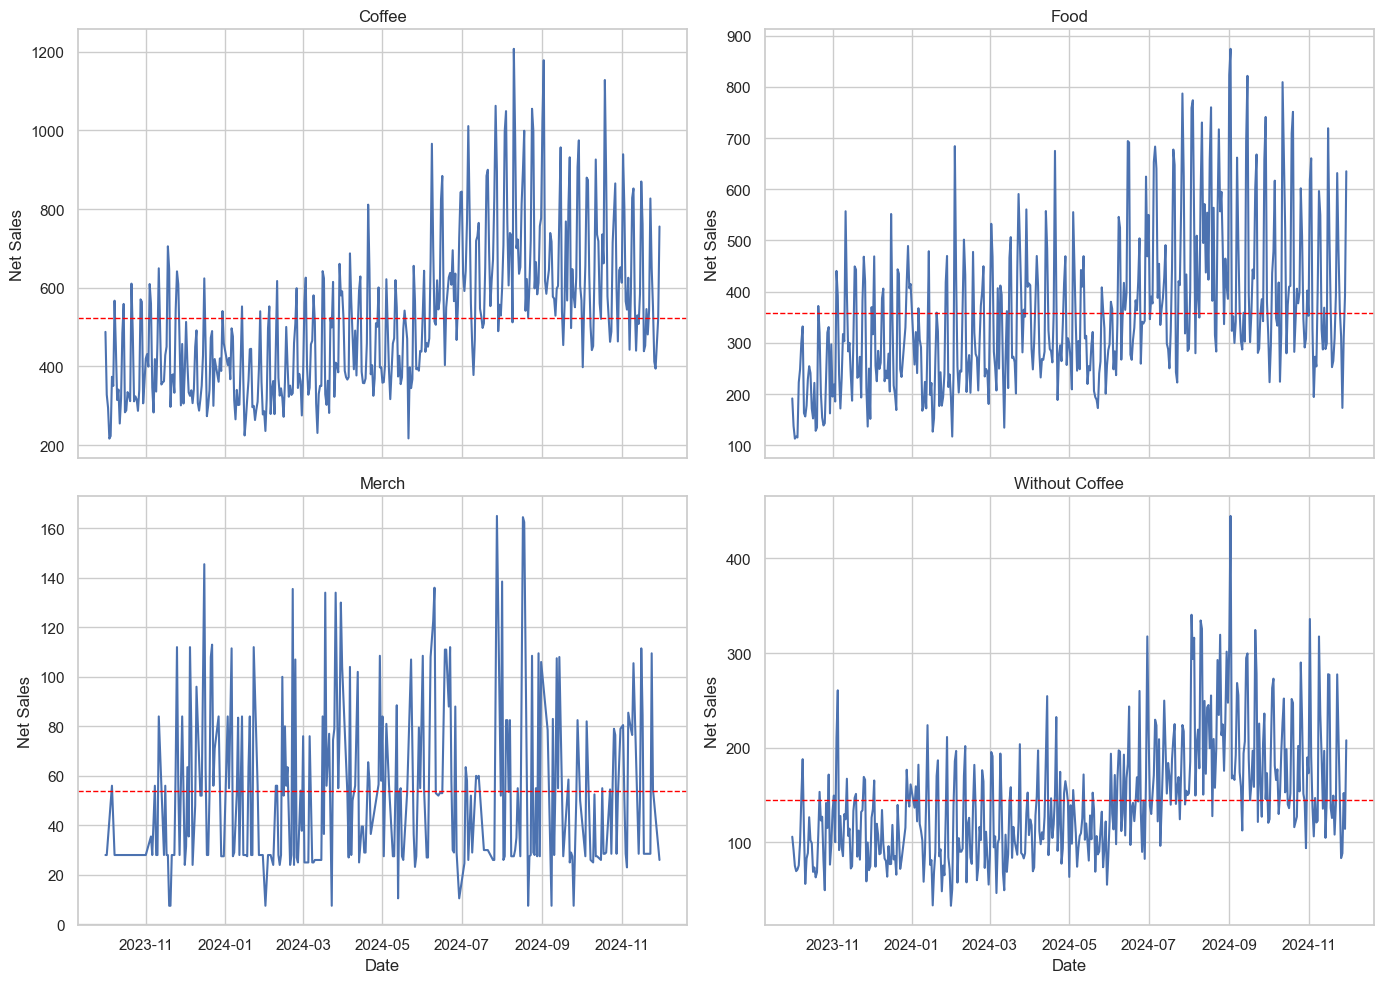

In [320]:
# Set the seaborn style
sns.set(style="whitegrid")

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Plot each category
for ax, column in zip(axes.flatten(), category_sales.drop(columns='closed').columns):
    sns.lineplot(data=category_sales, x=category_sales.index, y=column, ax=ax)
    ax.axhline(category_sales[column].mean(), color='red', linestyle='--', linewidth=1)
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Net Sales')

# Adjust layout
plt.tight_layout()
plt.show()

In [321]:
category_sales.drop(columns='closed').describe()

Category Name       Coffee        Food       Merch  Without Coffee
count           421.000000  421.000000  277.000000      421.000000
mean            522.027672  358.378029   53.950722      145.035938
std             188.559475  149.403909   33.166768       63.585073
min             216.400000  112.850000    7.500000       32.900000
25%             369.180000  249.700000   28.000000       97.150000
50%             496.700000  323.500000   50.500000      134.870000
75%             622.000000  423.450000   78.000000      177.050000
max            1207.170000  874.380000  165.000000      444.880000

In [322]:
mean_sales = category_sales.drop(columns='closed').mean().sort_values(ascending=False)
std_sales = category_sales.drop(columns='closed').std().sort_values(ascending=False)

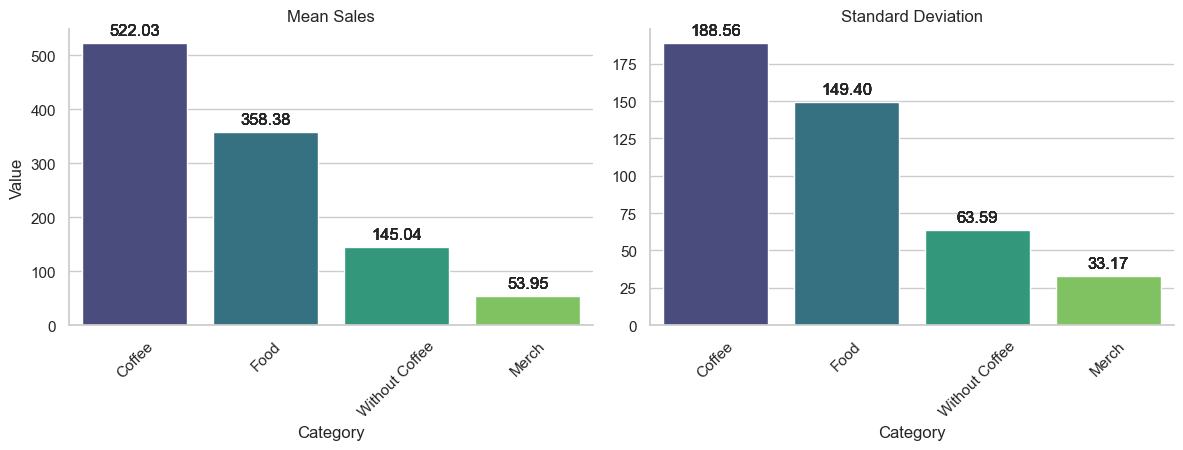

In [323]:
# Combine mean and standard deviation into a single DataFrame for easier plotting
sales_stats = pd.DataFrame({
    'Category': mean_sales.index,
    'Mean Sales': mean_sales.values,
    'Standard Deviation': std_sales.values
})

# Melt the DataFrame to long format for FacetGrid
sales_stats_melted = sales_stats.melt(id_vars='Category', var_name='Metric', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(sales_stats_melted, col='Metric', sharey=False, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='Category', y='Value', palette='viridis', hue='Category', dodge=False)

# Adjust the titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Category', 'Value')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        # Add number labels on each bar
        for ax in g.axes.flat:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()


In [324]:
category_sales.fillna(0, inplace=True)

In [325]:
category_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2023-10-01 to 2024-11-30
Freq: D
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Coffee          427 non-null    float64
 1   Food            427 non-null    float64
 2   Merch           427 non-null    float64
 3   closed          427 non-null    int64  
 4   Without Coffee  427 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 20.0 KB


##### Description of the dataframe:


In [386]:
category_data = pd.concat([category_sales, holiday_features, pedestrinization, time_features, macroeconomic, weather_clean, daily_sales], axis=1)

In [387]:
category_data.to_csv('data/category_data.csv')

- `Category`: Cateogy of products.
- `Net Sales`: Total net sales per day.
- `CPI, Unemployment Rate, Bond Yields`: Self-described macroeconomic indicators, forward filled to achieve daily frequency.
- `tavg`: Average temperature per day.
- `tmin`: Minimum temperature per day.
- `tmax`: Maximum temperature per day.
- `prcp`: Average precipitation total in mm per day.
- `wdir`: Average wind direction in degrees.
- `wspd`: Average wind speed per day.
- `pres`: Average sea level air pressure in hPa.
- `holiday_type_2`: Values (0, 1) where 0 indicates not a holiday, 1 indicates a major holiday
- `is_pedestrian`: Boolean flag (1 or 0) indicating whether the street where the cafe is located was pedestrianized on that day.
- `day_of_week`: Day of the week (0 = Monday, 6 = Sunday).
- `day_of_month`: Day of the month.
- `month`: Month of the year.
- `year`: Year.
- `quarter`: Quarter of the year (1 to 4).
- `is_weekend`: Boolean flag (1 or 0) indicating whether the day is a weekend.

In [620]:
category_data = pd.read_csv('data/category_data.csv', index_col = 0)
category_data.head()

Coffee    Food  Merch  closed  Without Coffee  holiday_type_2  \
2023-10-01  487.75  191.37   28.0       0          105.86               0   
2023-10-02  328.17  137.40   28.0       0           91.65               0   
2023-10-03  294.94  112.85    0.0       0           75.16               0   
2023-10-04  216.40  116.95    0.0       0           69.50               0   
2023-10-05  223.00  115.12    0.0       0           71.20               0   

            is_pedestrian  day_of_week  day_of_month  month  ...  \
2023-10-01              0            6             1     10  ...   
2023-10-02              0            0             2     10  ...   
2023-10-03              0            1             3     10  ...   
2023-10-04              0            2             4     10  ...   
2023-10-05              0            3             5     10  ...   

            Unemployment Rate  Bond Yields  tavg  tmin  tmax  prcp   wdir  \
2023-10-01                5.7     4.062000  18.4  13.0  25.0   0.0  344.0   
2023-10-02                5.7     4.050676  17.5  11.0  23.0   0.0  295.0   
2023-10-03                5.7     4.039352  21.1  17.0  27.0   0.0  227.0   
2023-10-04                5.7     4.028028  22.5  15.7  29.0   0.0  211.0   
2023-10-05                5.7     4.016704  22.8  18.6  28.0   0.0  156.0   

            wspd    pres  Net Sales  
2023-10-01   8.5  1023.7     852.98  
2023-10-02   7.2  1023.0     585.47  
2023-10-03  15.2  1018.7     504.45  
2023-10-04   9.5  1020.3     402.85  
2023-10-05  13.0  1018.0     413.62  

[5 rows x 24 columns]

In [621]:
category_data.columns.unique()

Index(['Coffee', 'Food', 'Merch', 'closed', 'Without Coffee', 'holiday_type_2',
       'is_pedestrian', 'day_of_week', 'day_of_month', 'month', 'year',
       'quarter', 'is_weekend', 'CPI', 'Unemployment Rate', 'Bond Yields',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'Net Sales'],
      dtype='object')

In [622]:
# Swap the positions of the columns
cols = list(category_data.columns)
without_coffee_index = cols.index('Without Coffee')
closed_index = cols.index('closed')

# Swap the columns
cols[without_coffee_index], cols[closed_index] = cols[closed_index], cols[without_coffee_index]

# Reorder the DataFrame
category_data = category_data[cols]
category_data.head()

Coffee    Food  Merch  Without Coffee  closed  holiday_type_2  \
2023-10-01  487.75  191.37   28.0          105.86       0               0   
2023-10-02  328.17  137.40   28.0           91.65       0               0   
2023-10-03  294.94  112.85    0.0           75.16       0               0   
2023-10-04  216.40  116.95    0.0           69.50       0               0   
2023-10-05  223.00  115.12    0.0           71.20       0               0   

            is_pedestrian  day_of_week  day_of_month  month  ...  \
2023-10-01              0            6             1     10  ...   
2023-10-02              0            0             2     10  ...   
2023-10-03              0            1             3     10  ...   
2023-10-04              0            2             4     10  ...   
2023-10-05              0            3             5     10  ...   

            Unemployment Rate  Bond Yields  tavg  tmin  tmax  prcp   wdir  \
2023-10-01                5.7     4.062000  18.4  13.0  25.0   0.0  344.0   
2023-10-02                5.7     4.050676  17.5  11.0  23.0   0.0  295.0   
2023-10-03                5.7     4.039352  21.1  17.0  27.0   0.0  227.0   
2023-10-04                5.7     4.028028  22.5  15.7  29.0   0.0  211.0   
2023-10-05                5.7     4.016704  22.8  18.6  28.0   0.0  156.0   

            wspd    pres  Net Sales  
2023-10-01   8.5  1023.7     852.98  
2023-10-02   7.2  1023.0     585.47  
2023-10-03  15.2  1018.7     504.45  
2023-10-04   9.5  1020.3     402.85  
2023-10-05  13.0  1018.0     413.62  

[5 rows x 24 columns]

In [623]:
category_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 427 entries, 2023-10-01 to 2024-11-30
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Coffee             427 non-null    float64
 1   Food               427 non-null    float64
 2   Merch              427 non-null    float64
 3   Without Coffee     427 non-null    float64
 4   closed             427 non-null    int64  
 5   holiday_type_2     427 non-null    int64  
 6   is_pedestrian      427 non-null    int64  
 7   day_of_week        427 non-null    int64  
 8   day_of_month       427 non-null    int64  
 9   month              427 non-null    int64  
 10  year               427 non-null    int64  
 11  quarter            427 non-null    int64  
 12  is_weekend         427 non-null    int64  
 13  CPI                427 non-null    float64
 14  Unemployment Rate  427 non-null    float64
 15  Bond Yields        427 non-null    float64
 16  tavg           

##### Correlation
**Examination of the correlation among features and target variables.**

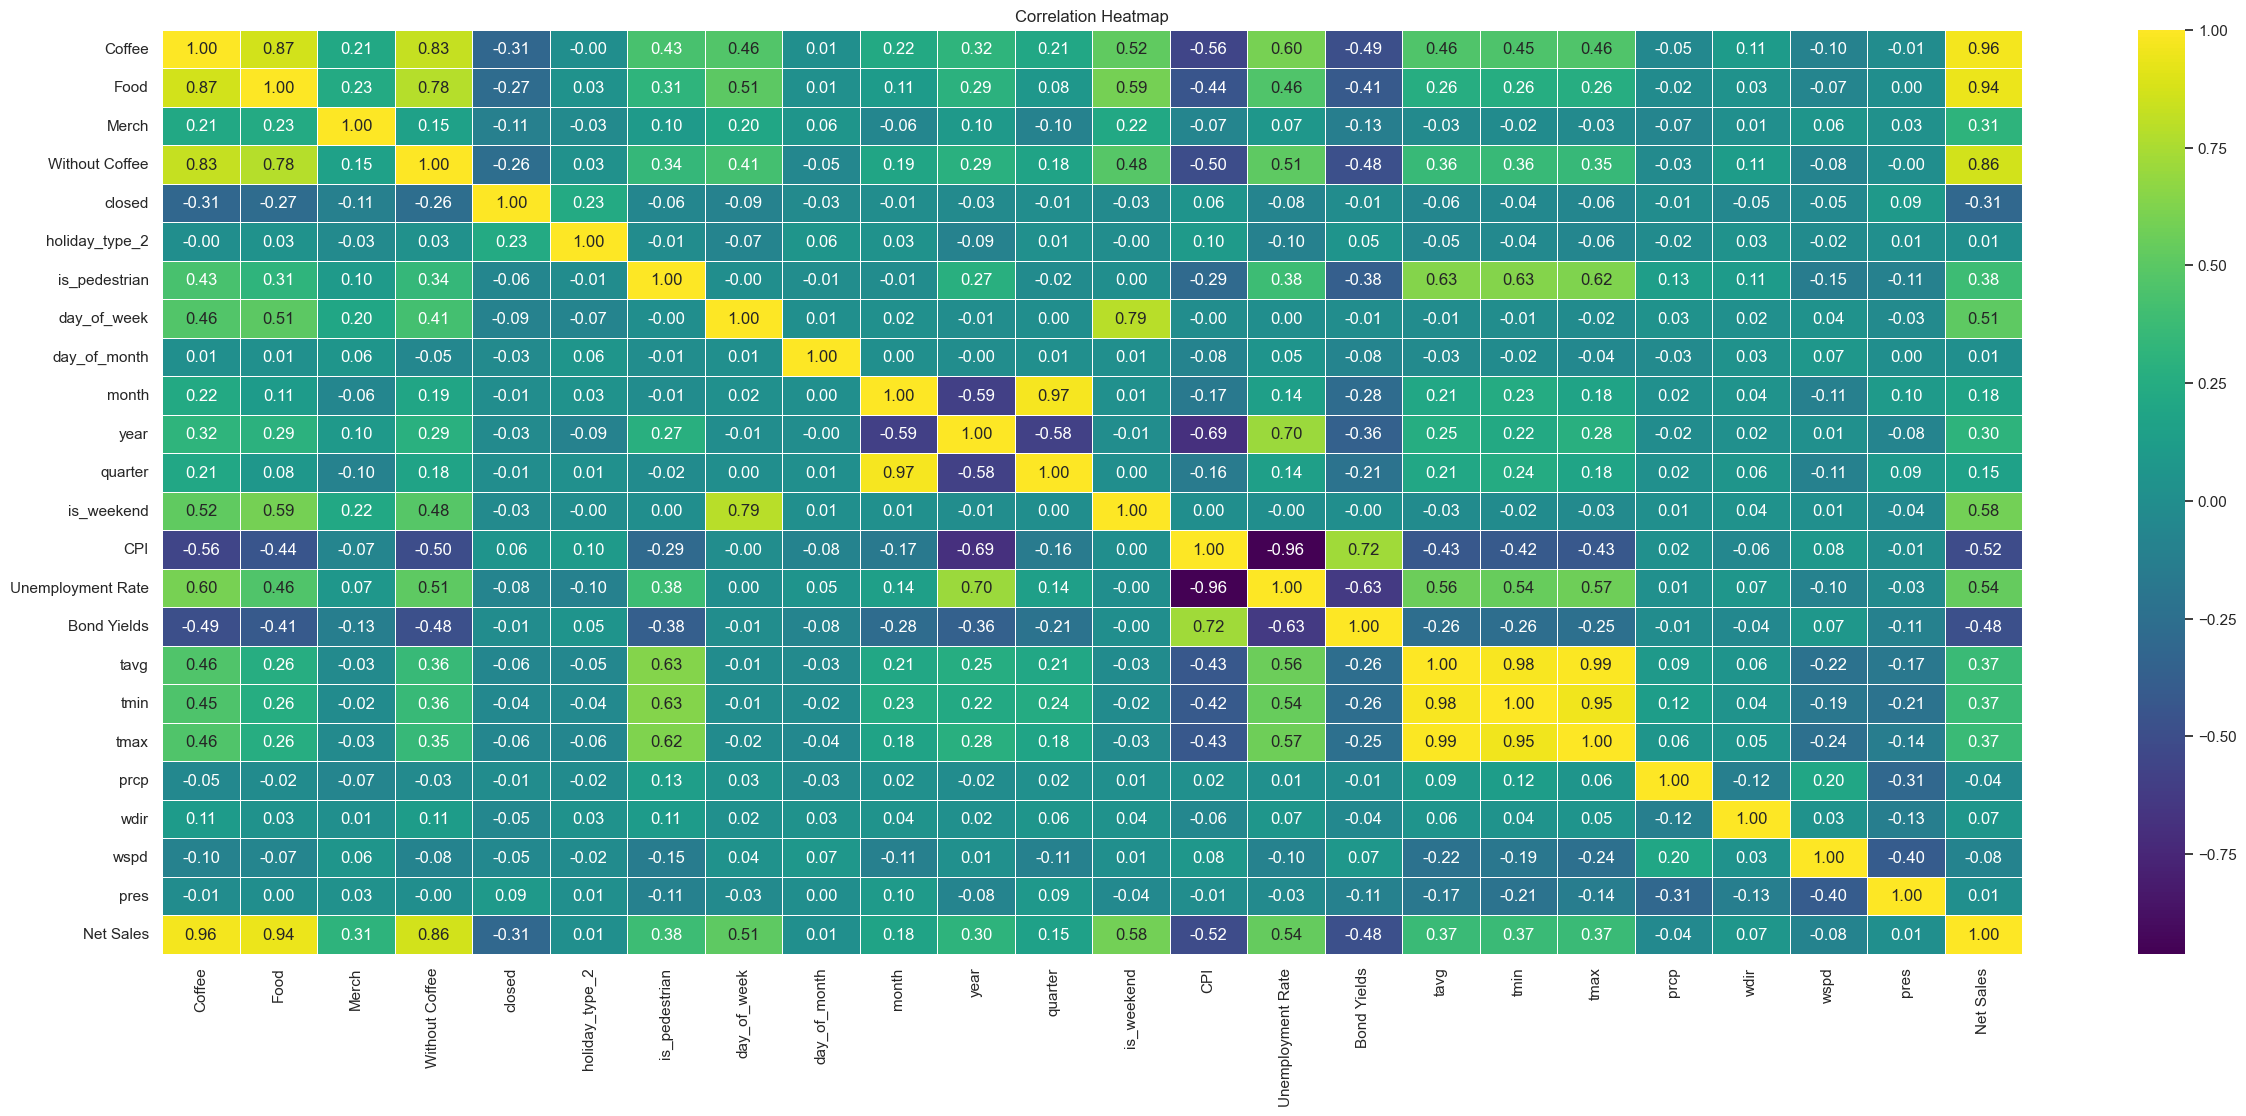

Coffee      Food     Merch  Without Coffee    closed  \
Coffee          1.000000  0.867346  0.213101        0.830675 -0.312149   
Food            0.867346  1.000000  0.227618        0.781524 -0.273802   
Merch           0.213101  0.227618  1.000000        0.153578 -0.112704   
Without Coffee  0.830675  0.781524  0.153578        1.000000 -0.261301   
closed         -0.312149 -0.273802 -0.112704       -0.261301  1.000000   
...                  ...       ...       ...             ...       ...   
prcp           -0.046347 -0.022014 -0.066864       -0.032362 -0.013009   
wdir            0.105736  0.031643  0.010943        0.112847 -0.051539   
wspd           -0.096544 -0.067959  0.064589       -0.082073 -0.046781   
pres           -0.012785  0.002595  0.025862       -0.002346  0.091140   
Net Sales       0.963882  0.943113  0.308026        0.864997 -0.306795   

                holiday_type_2  is_pedestrian  day_of_week  day_of_month  \
Coffee               -0.000437       0.430385     0.464838      0.007377   
Food                  0.028361       0.311175     0.505078      0.012783   
Merch                -0.029701       0.099853     0.200770      0.058539   
Without Coffee        0.025137       0.343713     0.410589     -0.054380   
closed                0.231775      -0.062128    -0.089536     -0.030573   
...                        ...            ...          ...           ...   
prcp                 -0.020818       0.131410     0.028170     -0.032242   
wdir                  0.029480       0.107660     0.018820      0.032554   
wspd                 -0.020045      -0.147410     0.039995      0.073053   
pres                  0.006403      -0.107385    -0.028094      0.000458   
Net Sales             0.011345       0.380811     0.509718      0.007833   

                   month  ...  Unemployment Rate  Bond Yields      tavg  \
Coffee          0.220040  ...           0.597756    -0.493015  0.460350   
Food            0.105513  ...           0.456380    -0.412467  0.258564   
Merch          -0.060578  ...           0.073565    -0.131037 -0.028736   
Without Coffee  0.189225  ...           0.514942    -0.484398  0.356729   
closed         -0.008504  ...          -0.078992    -0.012325 -0.057767   
...                  ...  ...                ...          ...       ...   
prcp            0.017396  ...           0.011865    -0.012433  0.090892   
wdir            0.042935  ...           0.072240    -0.042896  0.055660   
wspd           -0.114830  ...          -0.095087     0.073005 -0.219835   
pres            0.096114  ...          -0.029095    -0.107664 -0.174336   
Net Sales       0.177208  ...           0.536823    -0.482202  0.369929   

                    tmin      tmax      prcp      wdir      wspd      pres  \
Coffee          0.449655  0.459939 -0.046347  0.105736 -0.096544 -0.012785   
Food            0.255436  0.256854 -0.022014  0.031643 -0.067959  0.002595   
Merch          -0.022474 -0.030614 -0.066864  0.010943  0.064589  0.025862   
Without Coffee  0.356617  0.349113 -0.032362  0.112847 -0.082073 -0.002346   
closed         -0.044649 -0.062512 -0.013009 -0.051539 -0.046781  0.091140   
...                  ...       ...       ...       ...       ...       ...   
prcp            0.120960  0.064878  1.000000 -0.120626  0.202775 -0.308825   
wdir            0.044687  0.054229 -0.120626  1.000000  0.033578 -0.127073   
wspd           -0.185382 -0.241760  0.202775  0.033578  1.000000 -0.396142   
pres           -0.213824 -0.136396 -0.308825 -0.127073 -0.396142  1.000000   
Net Sales       0.365054  0.367808 -0.040115  0.066776 -0.080632  0.007119   

                Net Sales  
Coffee           0.963882  
Food             0.943113  
Merch            0.308026  
Without Coffee   0.864997  
closed          -0.306795  
...                   ...  
prcp            -0.040115  
wdir             0.066776  
wspd            -0.080632  
pres             0.007119  
Net Sales        1.000000  

[24 rows x 24 columns]

In [624]:
vs.plot_correlation_heatmap(category_data)

In [625]:
category_data = pd.get_dummies(category_data, columns=['quarter', 'day_of_week'])

In [626]:
category_data = category_data.drop(columns = ['Net Sales'])
category_data = category_data.drop(columns = ['day_of_month', 'month', 'pres', 'wdir', 'tmin', 'tmax'])

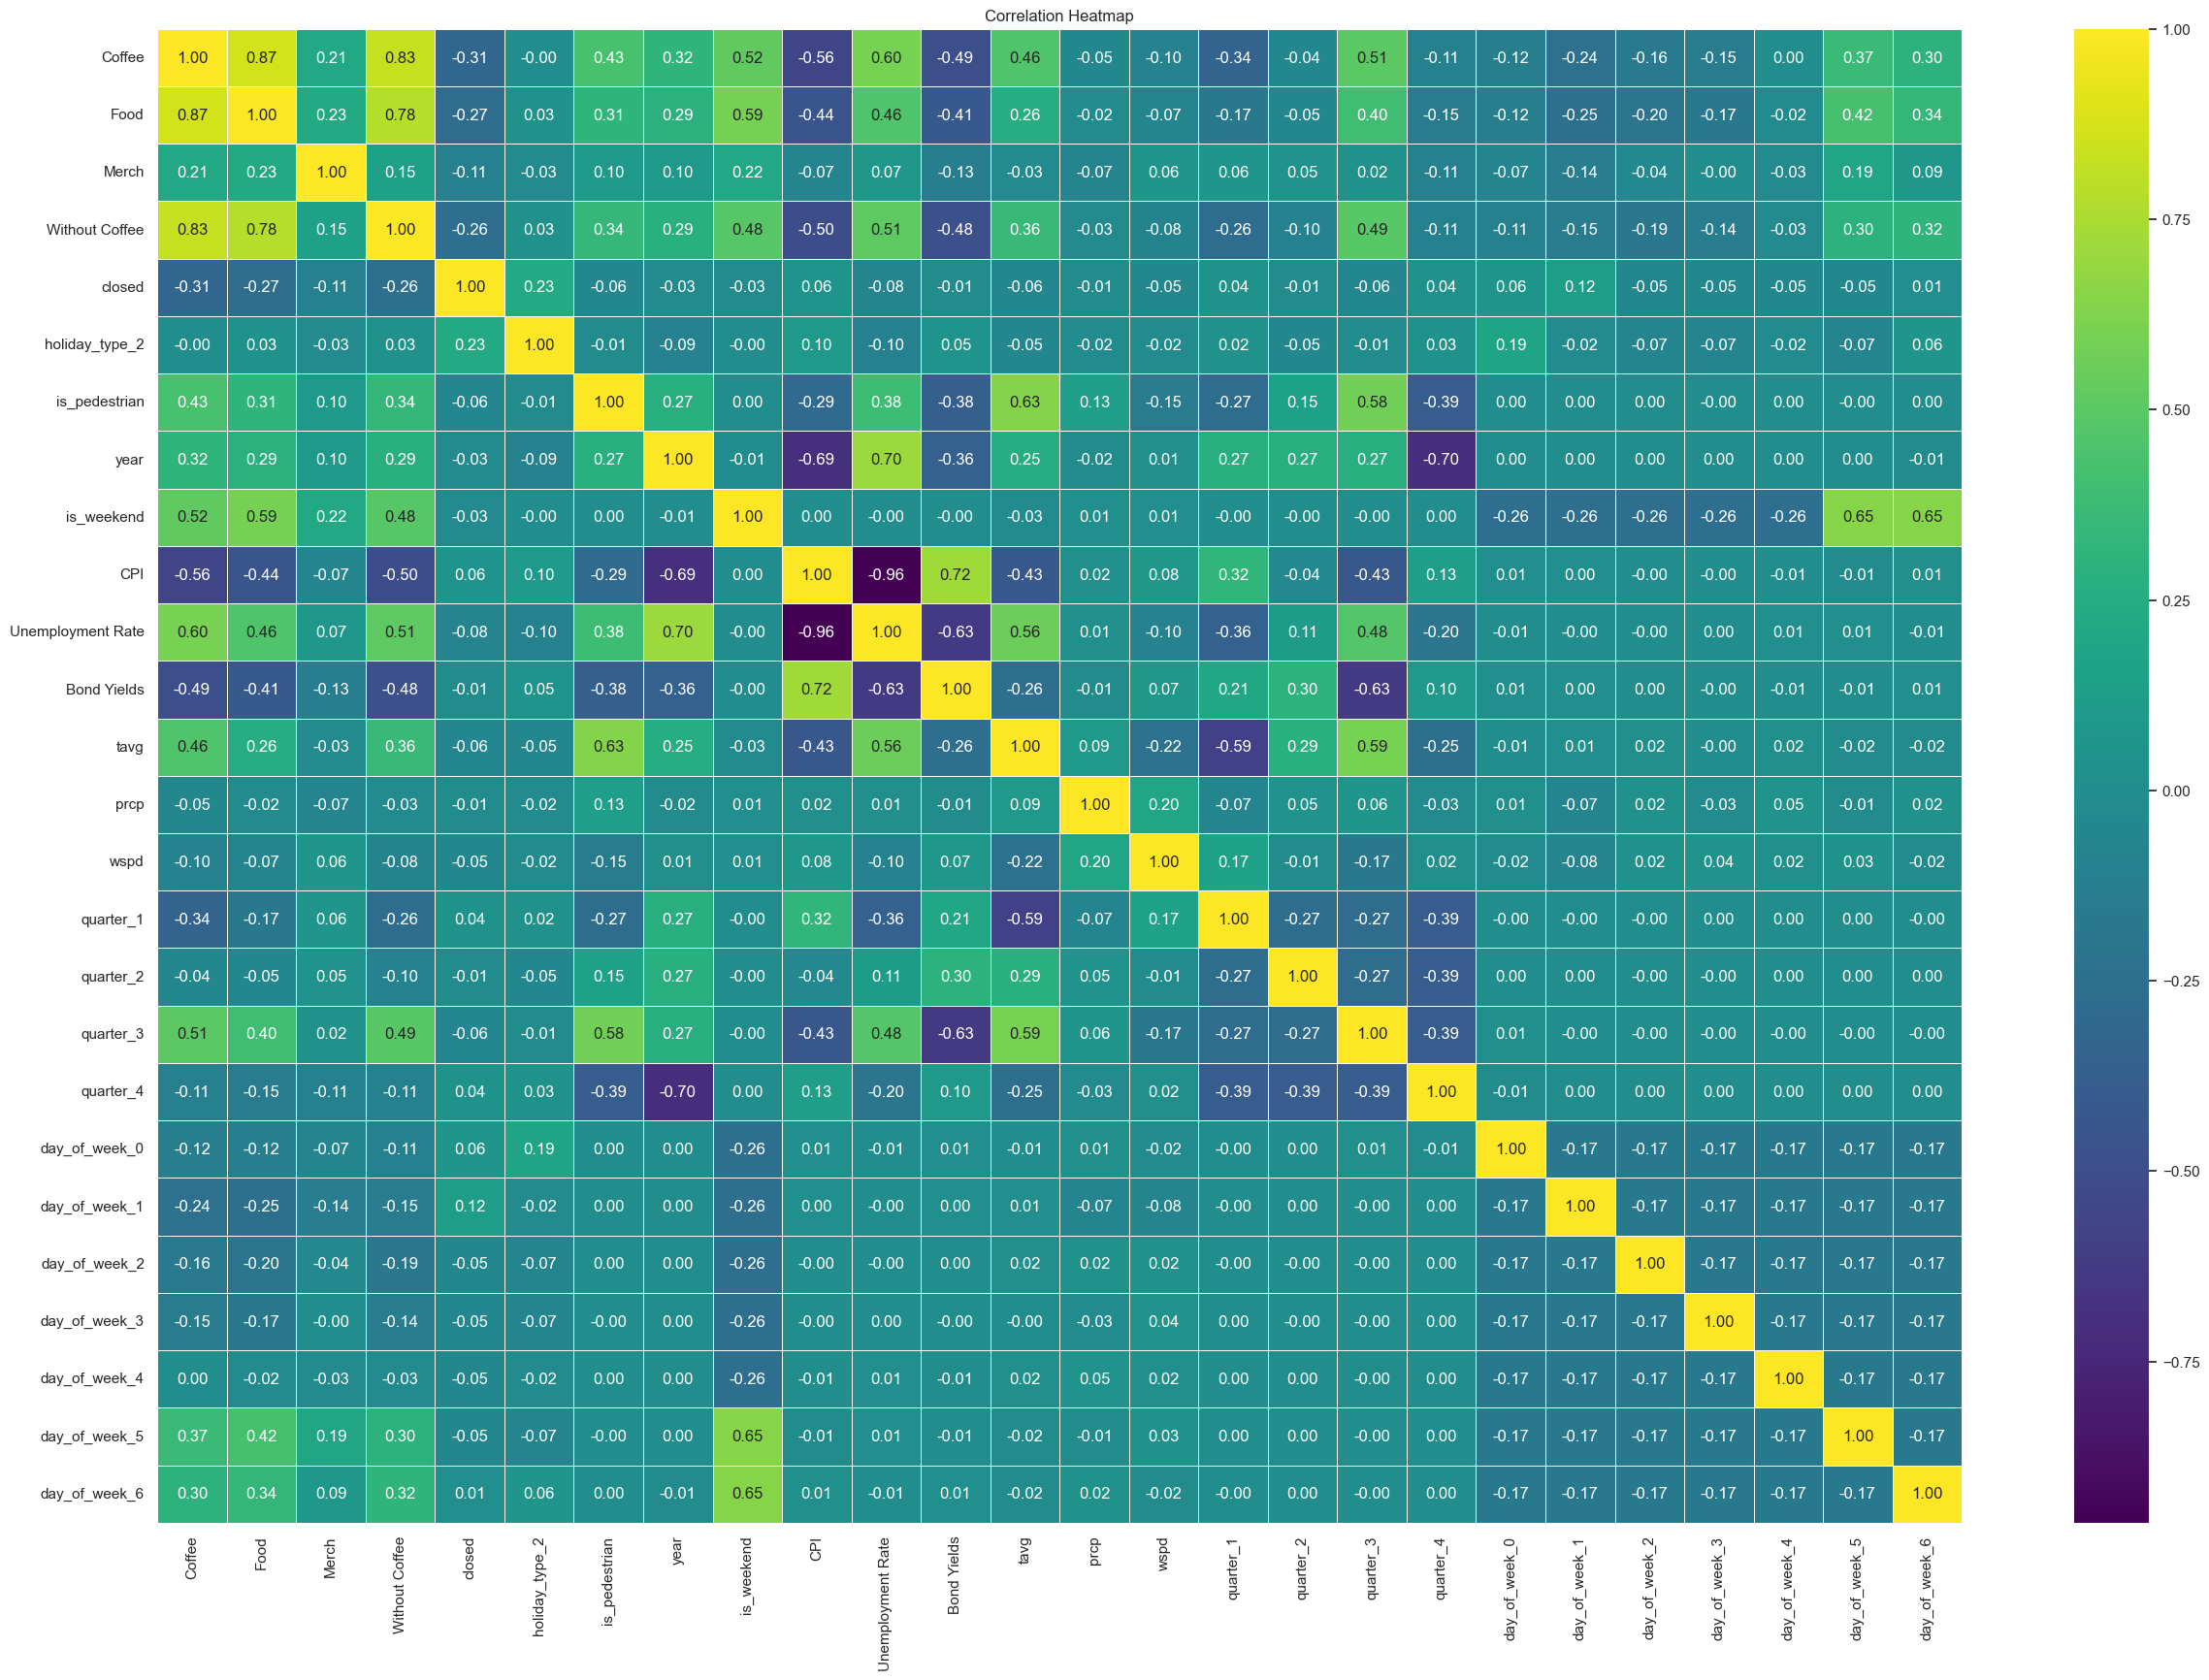

In [627]:
corr_matrix = vs.plot_correlation_heatmap(category_data, figsize=(30, 20))


- There are some features that are redundant.
    - `day_of_week_5` and `day_of_week_6` are highly correlated with `is_weekend` since they are representing the same information.

In [628]:
category_data = category_data.drop(columns = ['day_of_week_5', 'day_of_week_6'])

In [629]:
category_data = category_data.drop(columns = ['Merch'])

##### Feature importance (XGBoost)
**Examination of the feature importance in order to further focus on the most relevant features.**

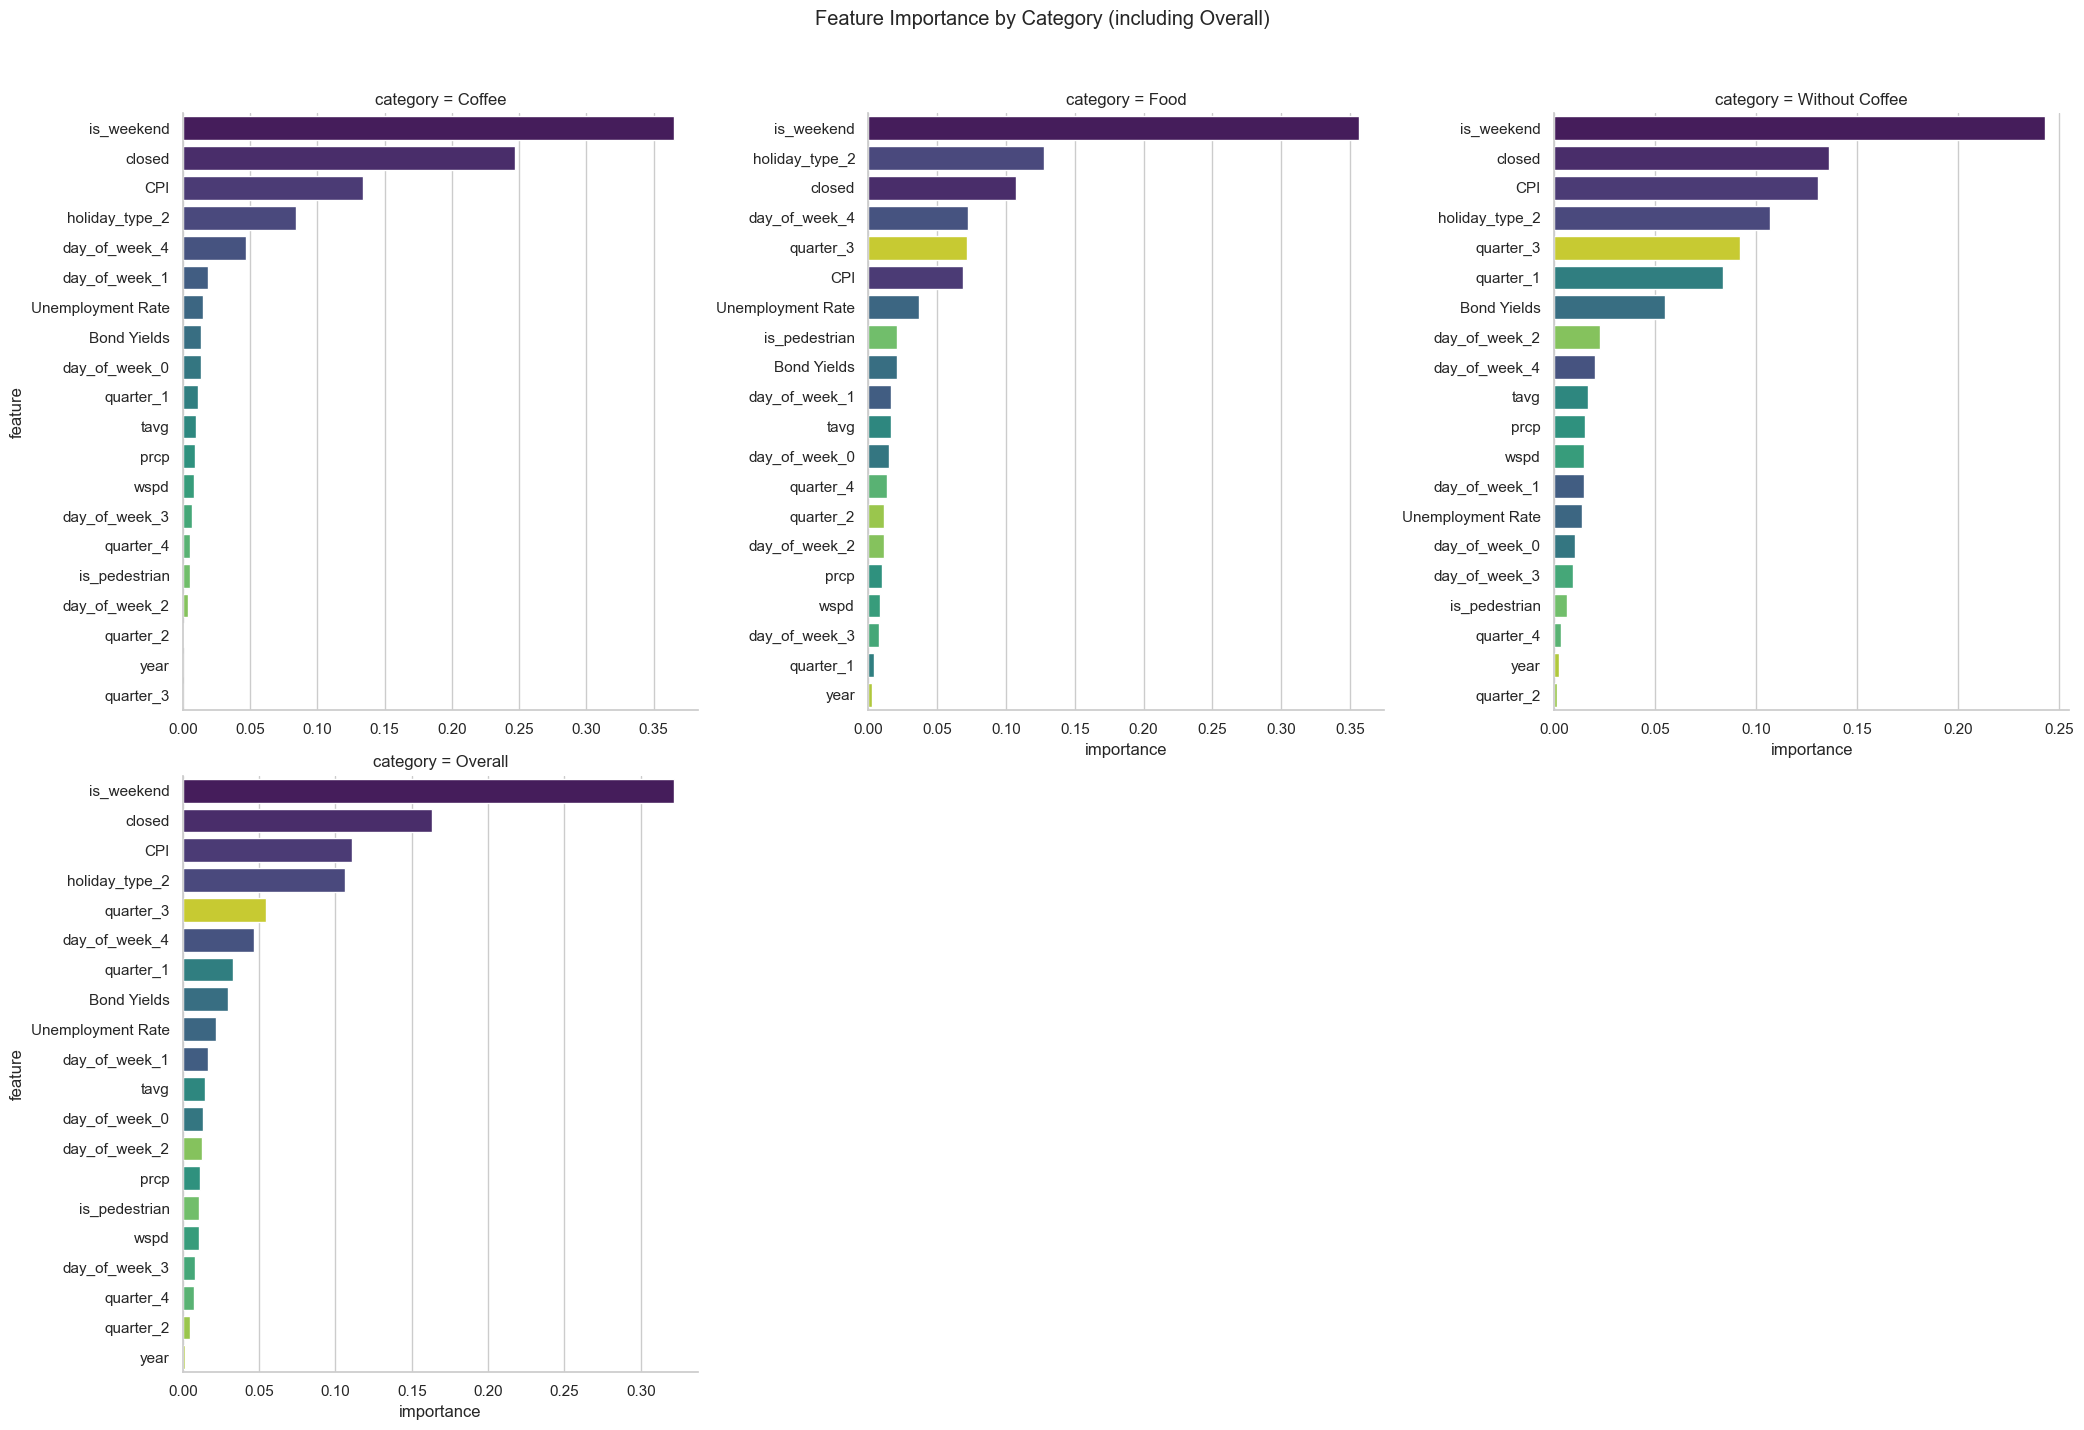

In [630]:
# Feature importnance for the 3 categories
categories = category_data.columns[:3]
importance_data = mt.analyze_category_feature_importance(category_data, categories)

**Insights from feature importance analysis**
- **Holiday type**
    - The `holiday_type_2` feature seem to provide valuable information to the model afterall, even though it didn't have direct impact on sales as shown from the correlation analysis.
- **Macroeconomic features**
    - They seem to also play an important role, with `CPI` being the most important features for almost all categories.
- **Weather**
    - The wind and temperature features are the most relevant features
- **Time based features**
    - These features seem to play a role in the decision making for XGBoost, with quarters being an important factor.

##### Macroconomic feature analysis
**We've seen that the features `CPI`, `Unemployment Rate`, `Bond Yields` are significantly correlated with the sales per category.**

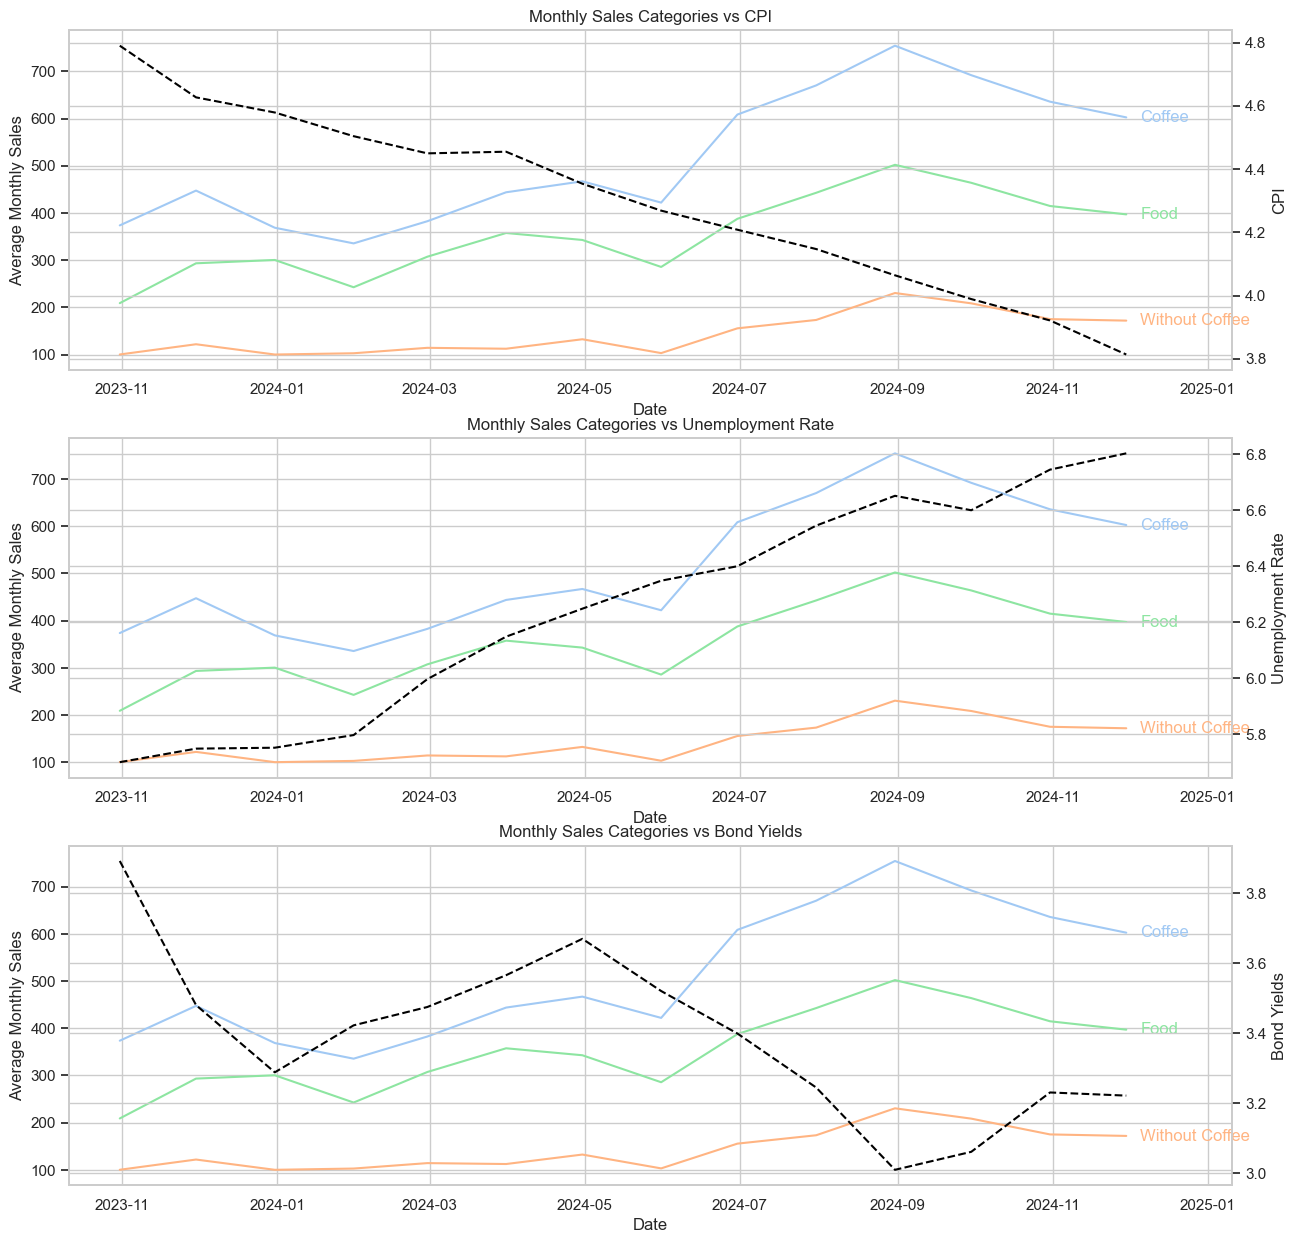

In [631]:
vs.plot_monthly_sales_vs_macro(category_data)

In [632]:
lags = [7, 10, 14, 30]
cols = ['CPI', 'Unemployment Rate', 'Bond Yields']
category_data = fe.create_lag_features(category_data, cols, lags).fillna(method='bfill')

##### Final correlation matrix
**Checking correlation of all features including lags and dummies.**

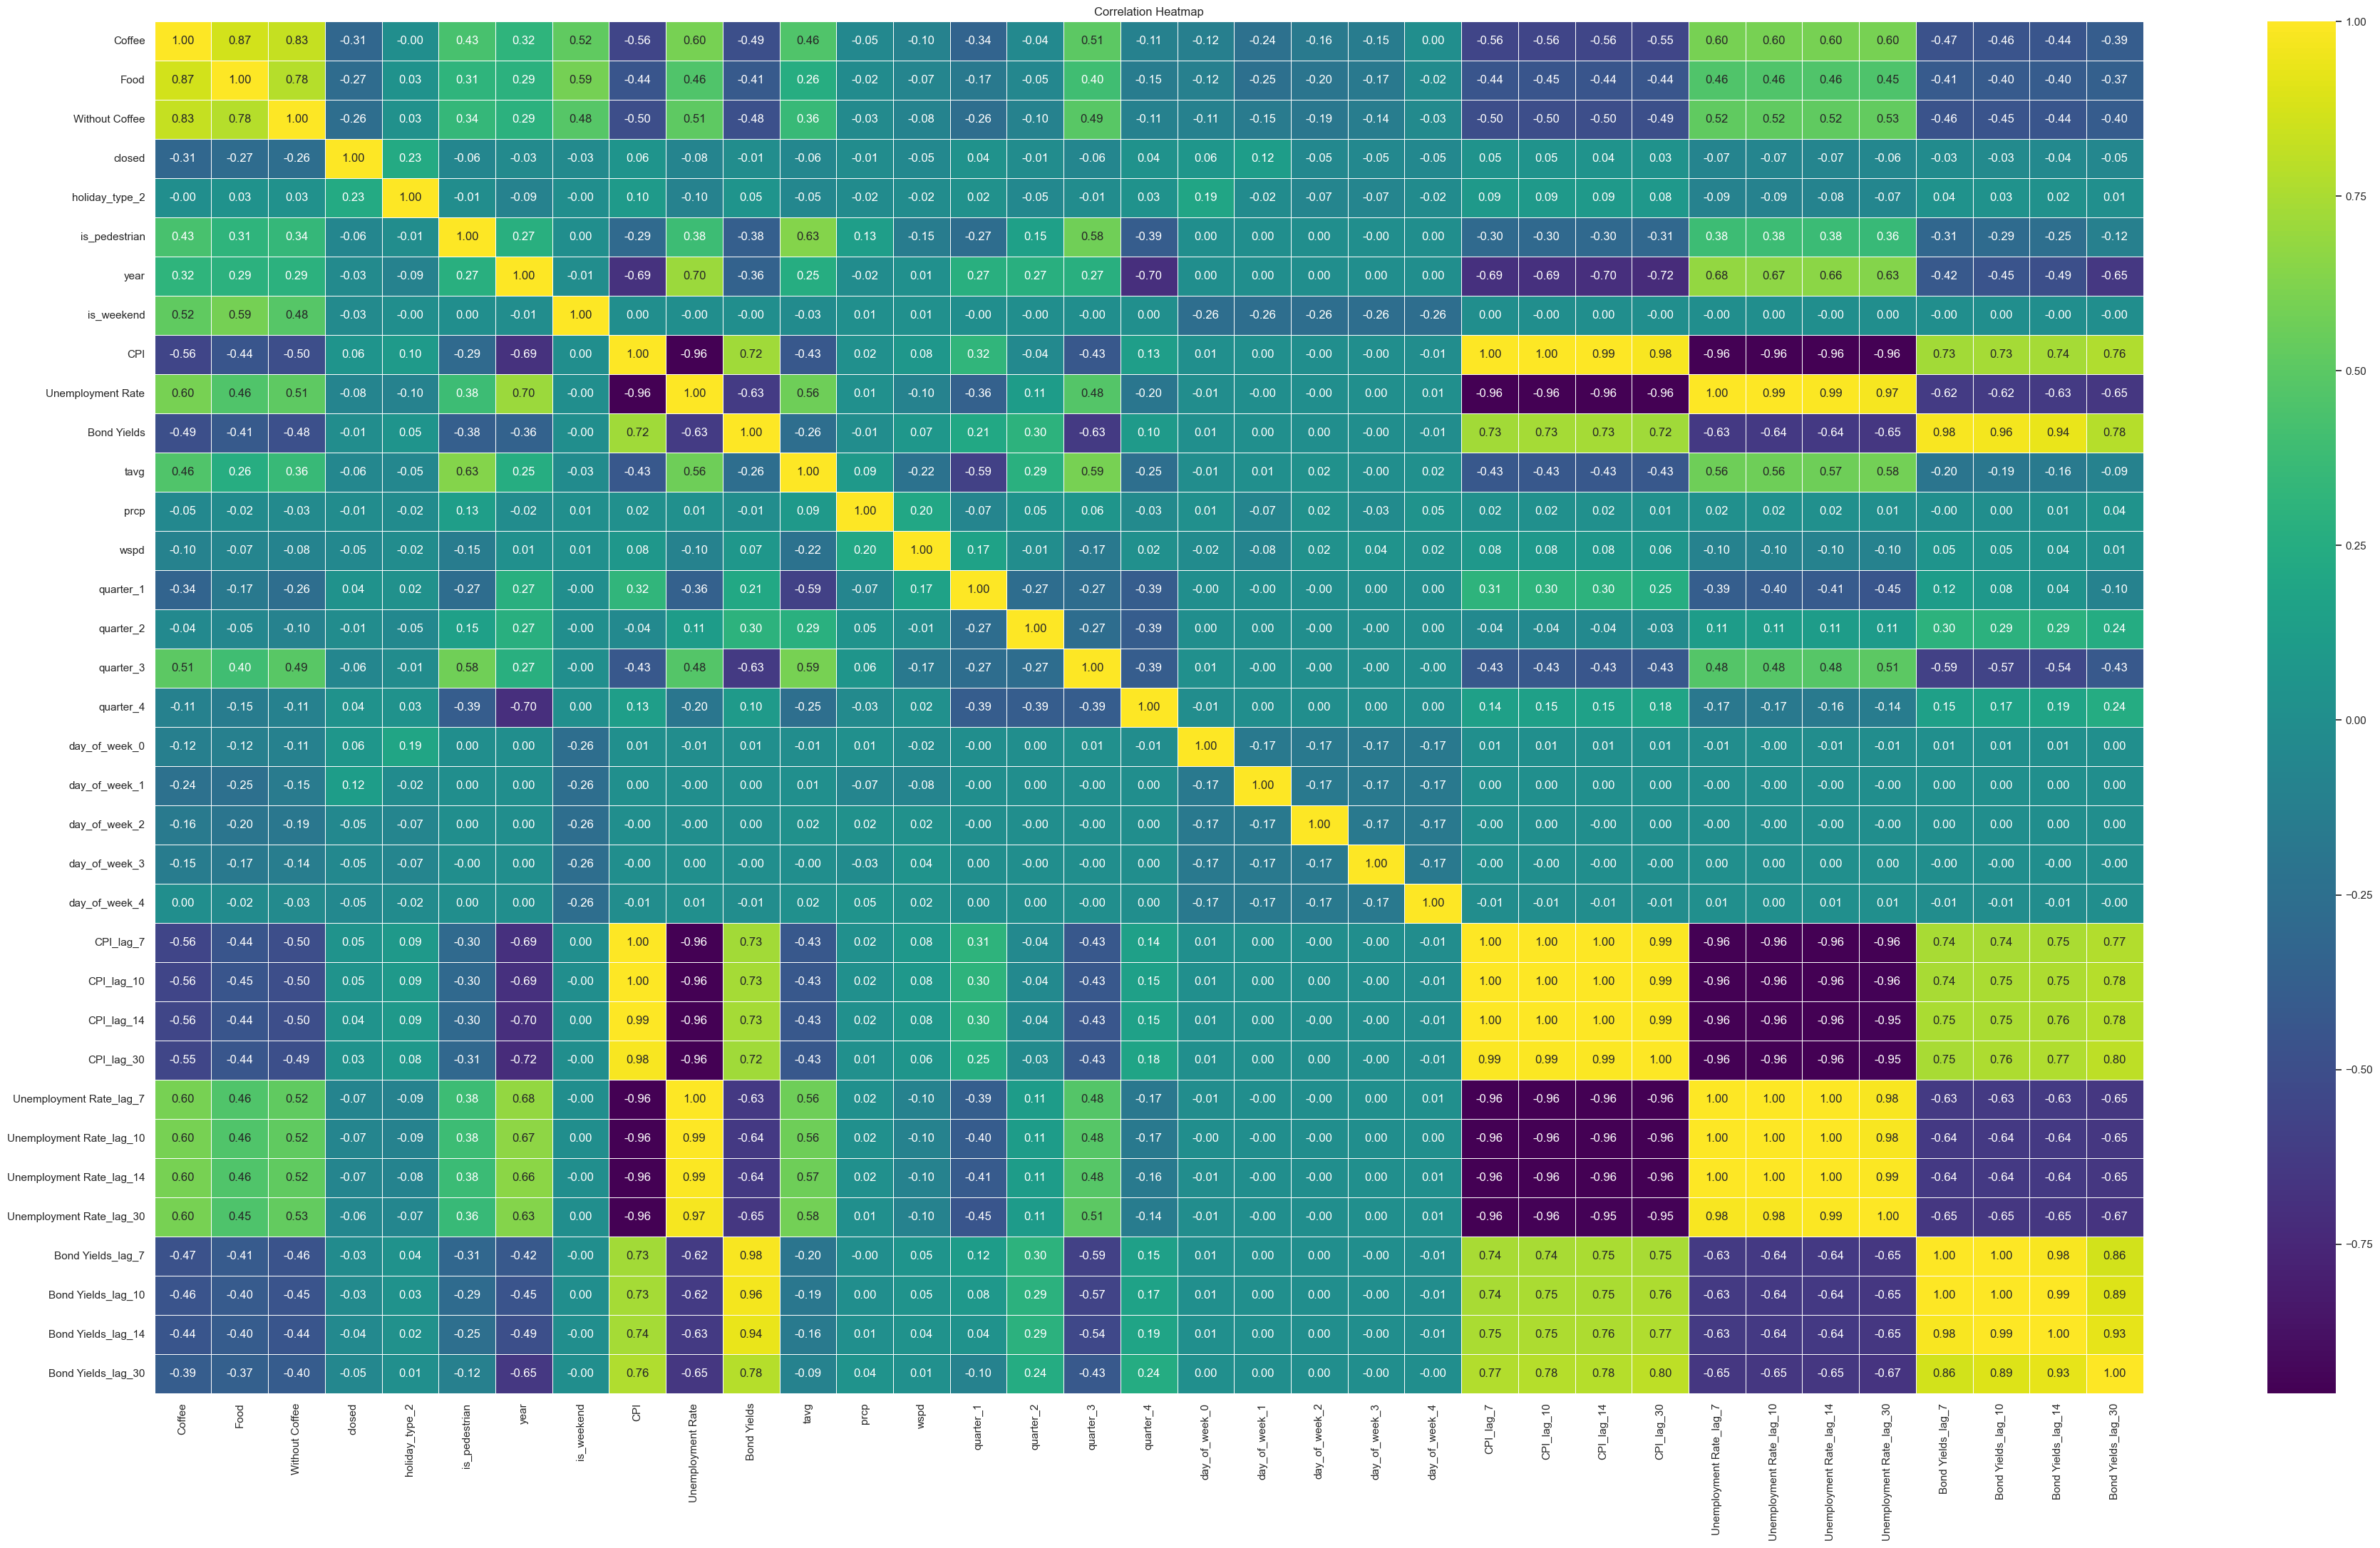

Coffee      Food  Without Coffee    closed  \
Coffee                    1.000000  0.867346        0.830675 -0.312149   
Food                      0.867346  1.000000        0.781524 -0.273802   
Without Coffee            0.830675  0.781524        1.000000 -0.261301   
closed                   -0.312149 -0.273802       -0.261301  1.000000   
holiday_type_2           -0.000437  0.028361        0.025137  0.231775   
...                            ...       ...             ...       ...   
Unemployment Rate_lag_30  0.598359  0.450330        0.531061 -0.056100   
Bond Yields_lag_7        -0.467914 -0.406782       -0.463893 -0.025353   
Bond Yields_lag_10       -0.457199 -0.404098       -0.454322 -0.031291   
Bond Yields_lag_14       -0.443997 -0.401474       -0.443538 -0.038823   
Bond Yields_lag_30       -0.392009 -0.369941       -0.403264 -0.053801   

                          holiday_type_2  is_pedestrian      year  is_weekend  \
Coffee                         -0.000437       0.430385  0.315716    0.521593   
Food                            0.028361       0.311175  0.292534    0.588502   
Without Coffee                  0.025137       0.343713  0.286563    0.479048   
closed                          0.231775      -0.062128 -0.034227   -0.031460   
holiday_type_2                  1.000000      -0.012428 -0.094563   -0.004675   
...                                  ...            ...       ...         ...   
Unemployment Rate_lag_30       -0.065755       0.362306  0.633227    0.000548   
Bond Yields_lag_7               0.036995      -0.313660 -0.424603   -0.000373   
Bond Yields_lag_10              0.030214      -0.287587 -0.453262    0.000018   
Bond Yields_lag_14              0.020848      -0.253248 -0.491559   -0.000356   
Bond Yields_lag_30              0.005601      -0.117766 -0.646907   -0.000575   

                               CPI  Unemployment Rate  ...  CPI_lag_14  \
Coffee                   -0.562541           0.597756  ...   -0.556585   
Food                     -0.442842           0.456380  ...   -0.444545   
Without Coffee           -0.503544           0.514942  ...   -0.496253   
closed                    0.055952          -0.078992  ...    0.041053   
holiday_type_2            0.096978          -0.103610  ...    0.088112   
...                            ...                ...  ...         ...   
Unemployment Rate_lag_30 -0.960275           0.969569  ...   -0.954905   
Bond Yields_lag_7         0.728169          -0.623911  ...    0.747930   
Bond Yields_lag_10        0.731900          -0.624496  ...    0.753165   
Bond Yields_lag_14        0.737058          -0.626507  ...    0.759737   
Bond Yields_lag_30        0.762467          -0.653001  ...    0.784057   

                          CPI_lag_30  Unemployment Rate_lag_7  \
Coffee                     -0.550928                 0.599255   
Food                       -0.439626                 0.456059   
Without Coffee             -0.488864                 0.519704   
closed                      0.028949                -0.074062   
holiday_type_2              0.080271                -0.093734   
...                              ...                      ...   
Unemployment Rate_lag_30   -0.954387                 0.979533   
Bond Yields_lag_7           0.746399                -0.633075   
Bond Yields_lag_10          0.755211                -0.633109   
Bond Yields_lag_14          0.766014                -0.633829   
Bond Yields_lag_30          0.801056                -0.649503   

                          Unemployment Rate_lag_10  Unemployment Rate_lag_14  \
Coffee                                    0.599330                  0.598457   
Food                                      0.456220                  0.455806   
Without Coffee                            0.521637                  0.523342   
closed                                   -0.071782                 -0.068770   
holiday_type_2                           -0.089493                 -0.083862   
...             

In [633]:
corr_matrix = vs.plot_correlation_heatmap(category_data, figsize=(45, 25))
corr_matrix

##### Final feature importance
**Checking feature importance of all features including lags and dummies.**

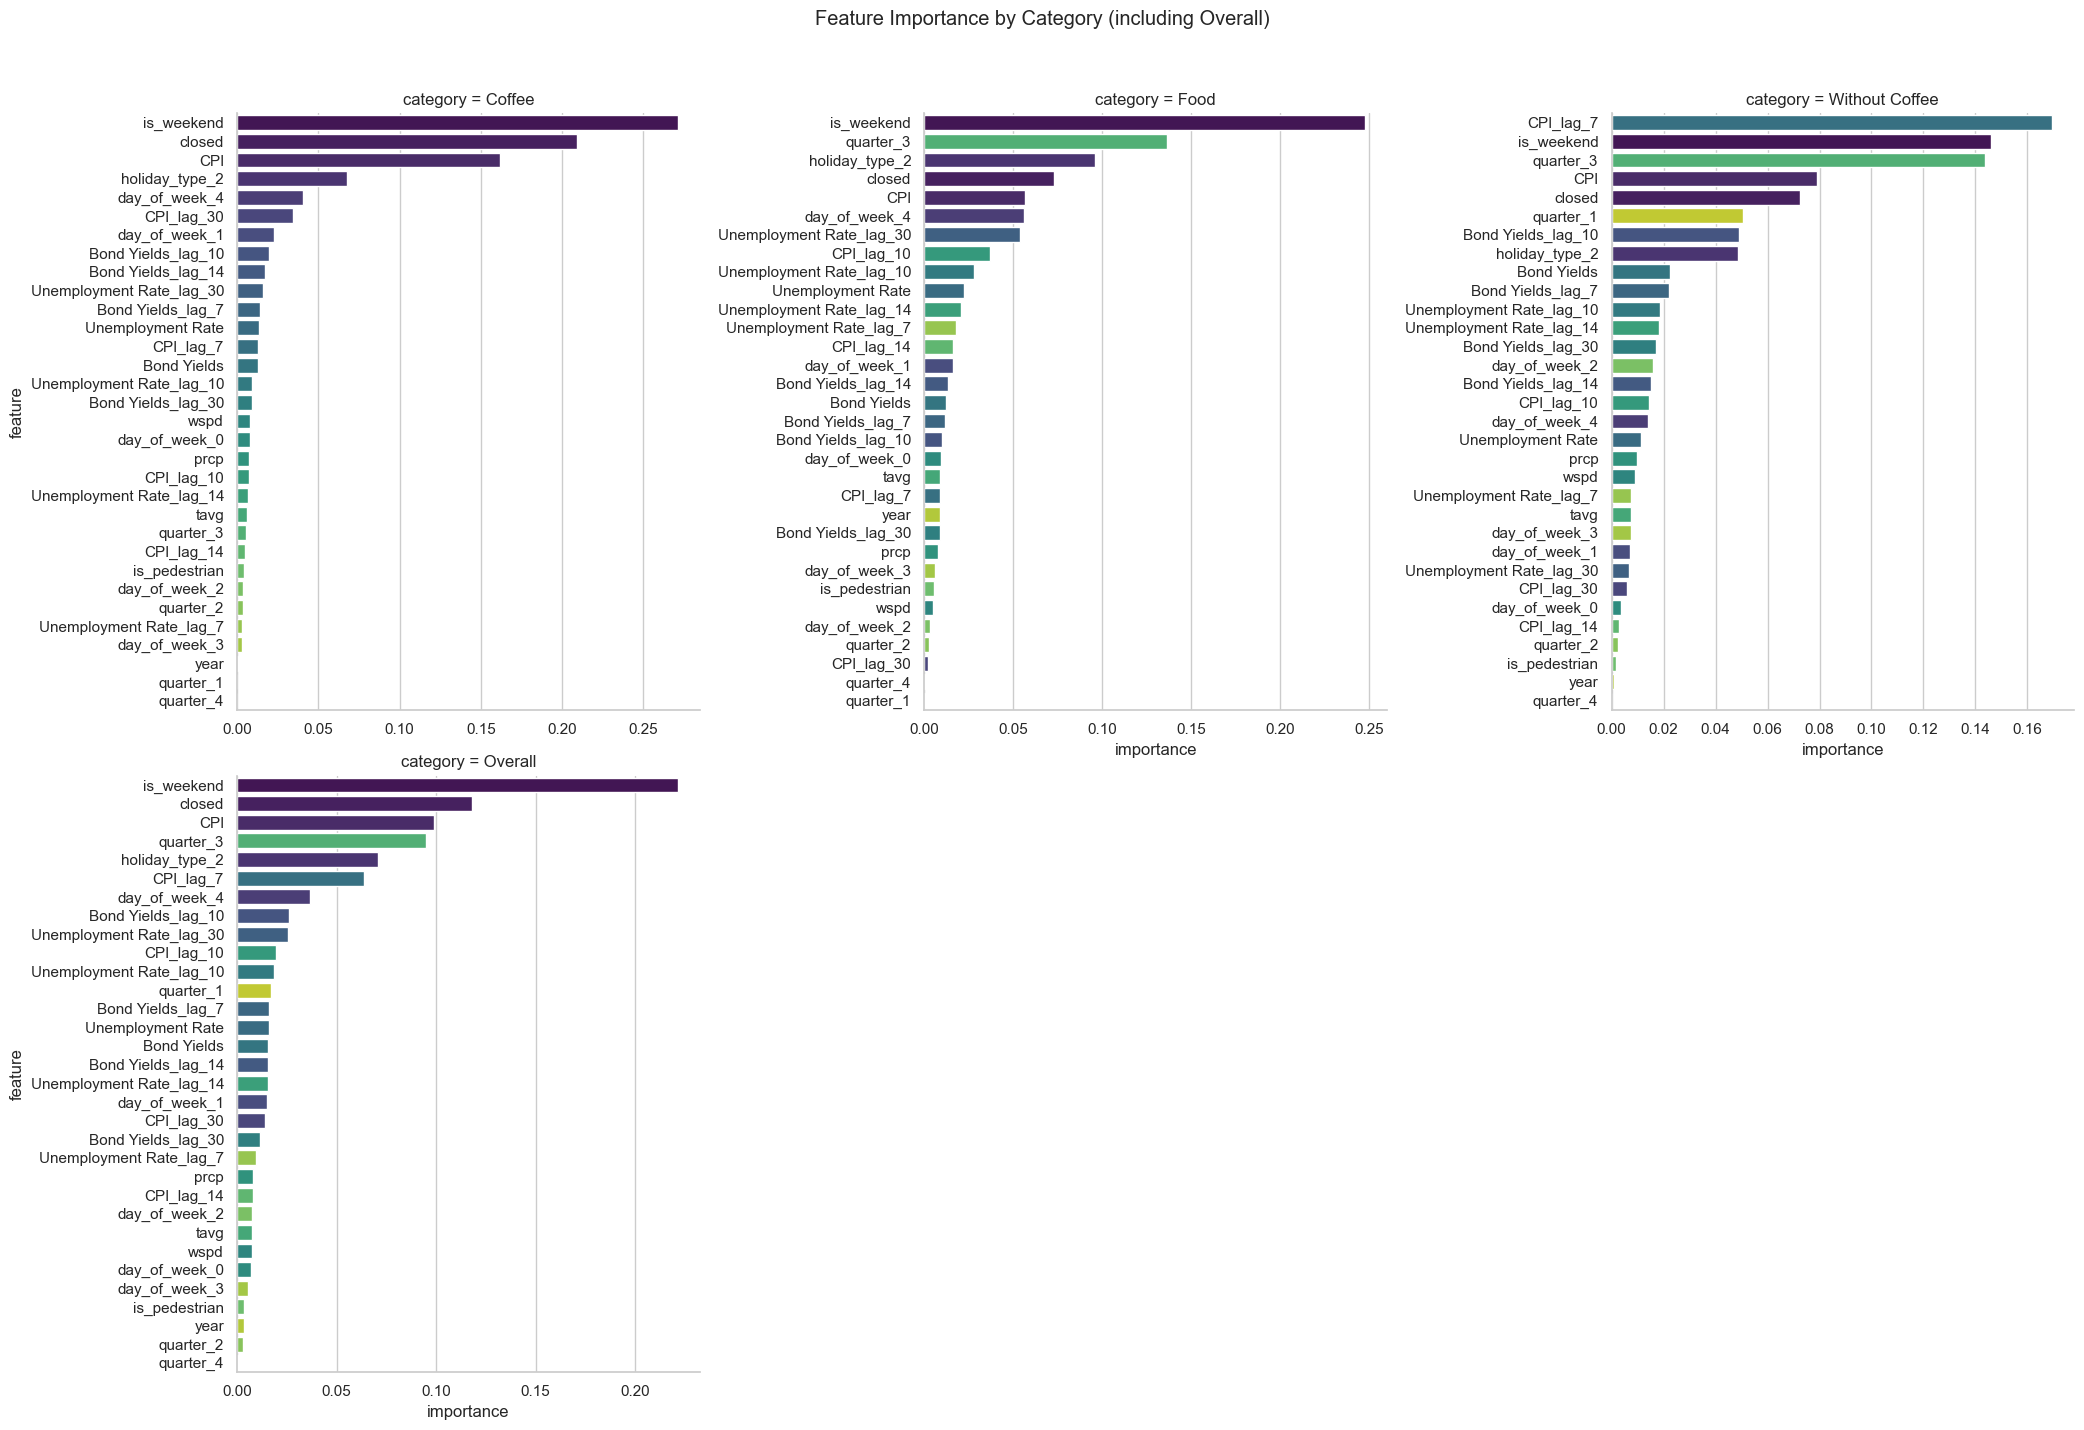

feature  importance category
96       is_weekend    0.221479  Overall
97           closed    0.118228  Overall
98              CPI    0.099119  Overall
99        quarter_3    0.095042  Overall
100  holiday_type_2    0.070627  Overall
..              ...         ...      ...
123   day_of_week_3    0.005284  Overall
124   is_pedestrian    0.003608  Overall
125            year    0.003452  Overall
126       quarter_2    0.002916  Overall
127       quarter_4    0.000126  Overall

[32 rows x 3 columns]

In [634]:
importance = mt.analyze_category_feature_importance(category_data, categories)
overall_importance = importance.loc[importance['category'] == 'Overall'].sort_values(by='importance', ascending=False)
overall_importance

In [635]:
# Removing features that have less than 0.01 feature importance
low_features = overall_importance.loc[(overall_importance['importance'] < 0.026) & (~overall_importance['feature'].isin(['is_pedestrian', 'tavg', 'wspd']))]
category_data_filtered = category_data.drop(columns=low_features['feature'])
category_data_filtered.columns

Index(['Coffee', 'Food', 'Without Coffee', 'closed', 'holiday_type_2',
       'is_pedestrian', 'is_weekend', 'CPI', 'tavg', 'wspd', 'quarter_3',
       'day_of_week_4', 'CPI_lag_7', 'Bond Yields_lag_10'],
      dtype='object')

In [636]:
category_data_filtered.to_csv('data/category_data_filtered.csv')

## Model Training
**Last feature engineering and training and evaluation of the 3 models.**

In [637]:
category_data_filtered = pd.read_csv('data/category_data_filtered.csv', index_col=0)
category_data_filtered.head()

Coffee    Food  Without Coffee  closed  holiday_type_2  \
2023-10-01  487.75  191.37          105.86       0               0   
2023-10-02  328.17  137.40           91.65       0               0   
2023-10-03  294.94  112.85           75.16       0               0   
2023-10-04  216.40  116.95           69.50       0               0   
2023-10-05  223.00  115.12           71.20       0               0   

            is_pedestrian  is_weekend       CPI  tavg  wspd  quarter_3  \
2023-10-01              0           1  4.882717  18.4   8.5      False   
2023-10-02              0           0  4.876541  17.5   7.2      False   
2023-10-03              0           0  4.870364  21.1  15.2      False   
2023-10-04              0           0  4.864188  22.5   9.5      False   
2023-10-05              0           0  4.858012  22.8  13.0      False   

            day_of_week_4  CPI_lag_7  Bond Yields_lag_10  
2023-10-01          False   4.882717               4.062  
2023-10-02          False   4.882717               4.062  
2023-10-03          False   4.882717               4.062  
2023-10-04          False   4.882717               4.062  
2023-10-05          False   4.882717               4.062

In [638]:
# Convert boolean features to integers
bool_columns = category_data_filtered.select_dtypes(include='bool').columns
category_data_filtered[bool_columns] = category_data_filtered[bool_columns].astype(int)

##### Extra feature engineering

In [639]:
# Create a new column 'before_holiday' initialized to 0
category_data_filtered['before_holiday'] = 0

# Convert the index to datetime
category_data_filtered.index = pd.to_datetime(category_data_filtered.index)

# Get the dates where holiday_type_1 is 1
holiday_dates = category_data_filtered[category_data_filtered['holiday_type_2'] == 1].index

# Iterate over each holiday date and set 'before_holiday' to 1 for the 3 days before the holiday
for holiday_date in holiday_dates:
    for i in range(1, 5):
        before_date = holiday_date - pd.Timedelta(days=i)
        if before_date in category_data_filtered.index:
            category_data_filtered.at[before_date, 'before_holiday'] = 1

In [640]:
category_data_filtered['tavg_weekend'] = category_data_filtered['tavg'] * category_data_filtered['is_weekend']

In [641]:
category_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2023-10-01 to 2024-11-30
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Coffee              427 non-null    float64
 1   Food                427 non-null    float64
 2   Without Coffee      427 non-null    float64
 3   closed              427 non-null    int64  
 4   holiday_type_2      427 non-null    int64  
 5   is_pedestrian       427 non-null    int64  
 6   is_weekend          427 non-null    int64  
 7   CPI                 427 non-null    float64
 8   tavg                427 non-null    float64
 9   wspd                427 non-null    float64
 10  quarter_3           427 non-null    int64  
 11  day_of_week_4       427 non-null    int64  
 12  CPI_lag_7           427 non-null    float64
 13  Bond Yields_lag_10  427 non-null    float64
 14  before_holiday      427 non-null    int64  
 15  tavg_weekend        427 non-null    fl

In [642]:
category_data_filtered.sort_index(inplace=True)

In [643]:
category_data_filtered.to_csv('data/data_final.csv')

In [644]:
data_final = pd.read_csv('data/data_final.csv', index_col=0)

In [645]:
data_final.columns

Index(['Coffee', 'Food', 'Without Coffee', 'closed', 'holiday_type_2',
       'is_pedestrian', 'is_weekend', 'CPI', 'tavg', 'wspd', 'quarter_3',
       'day_of_week_4', 'CPI_lag_7', 'Bond Yields_lag_10', 'before_holiday',
       'tavg_weekend'],
      dtype='object')

In [646]:
categories = ['Coffee', 'Without Coffee', 'Food']

**Removing outliers** <br>
> After testing treshold = 3 works best for XGBoost and treshold = 2 works best for Ridge

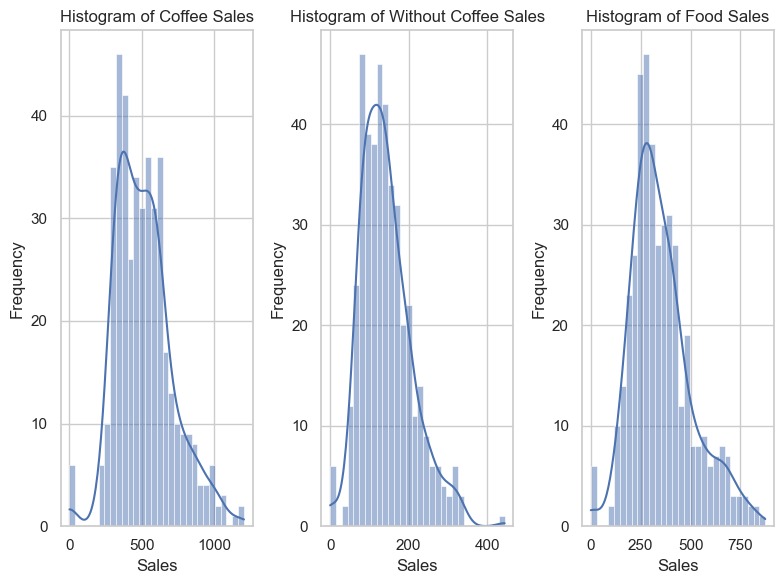

In [647]:
vs.hist_plot_categories(data_final, categories)

In [648]:
data_final_xgb = dp.remove_outliers(data_final, categories, 3)
data_final_ridge = dp.remove_outliers(data_final, categories, 2)

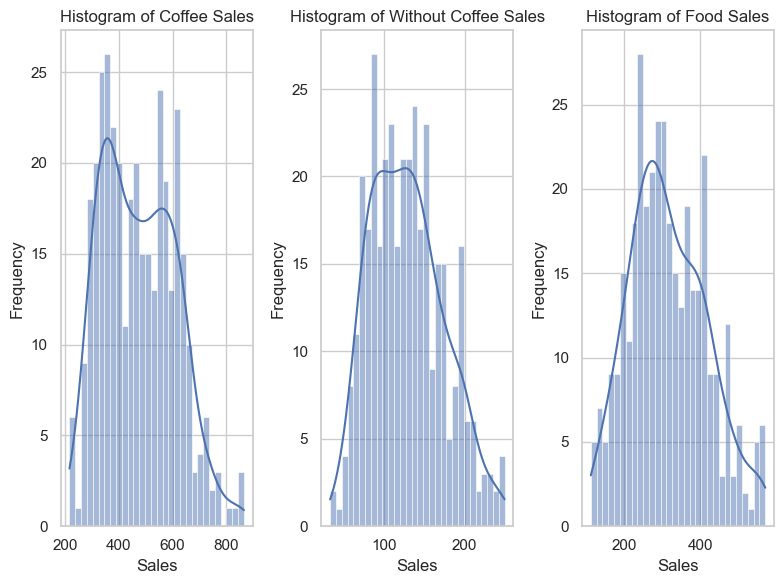

In [649]:
vs.hist_plot_categories(data_final_ridge, categories)

##### XGBoost

In [650]:
xgb_params_log = {
        'model__regressor__max_depth': [2, 3, 4],
        'model__regressor__learning_rate': [0.01, 0.05],
        'model__regressor__n_estimators': [100, 150, 200],
        'model__regressor__min_child_weight': [1, 5],
        'model__regressor__subsample': [0.8, 1.0],
        'model__regressor__colsample_bytree': [0.8, 1.0],
        'model__regressor__gamma': [0, 0.1],
        'model__regressor__nthread': [-1]
}

In [651]:
xgb_params_regularized_log= {
    **xgb_params_log,
    'model__regressor__reg_alpha': [0.01, 0.1, 1],            # L1 regularization
    'model__regressor__reg_lambda': [0.01, 0.1, 1]            # L2 regularization
}

In [652]:
results_xgb_log, summary_xgb_log, residuals_xgb_log, xgb_models = mt.xgb_train_log(data_final_xgb, categories, 6, xgb_params_regularized_log, date_split='2024-11-01')


Metrics for Coffee:
Training Metrics:
RMSE: 75.7627
MAPE: 12.1700
R2: 0.8322

Test Metrics:
RMSE: 66.7511
MAPE: 10.2673
R2: 0.7839

Metrics for Without Coffee:
Training Metrics:
RMSE: 31.4994
MAPE: 18.8986
R2: 0.7258

Test Metrics:
RMSE: 39.0525
MAPE: 22.0039
R2: 0.6041

Metrics for Food:
Training Metrics:
RMSE: 53.8747
MAPE: 12.2501
R2: 0.8601

Test Metrics:
RMSE: 65.8373
MAPE: 16.4903
R2: 0.7982


##### Ridge regression


In [654]:
ridge_params_log = {
    'model__regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'model__regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'model__regressor__fit_intercept': [True, False],
    'model__regressor__positive': [True, False]
}

In [655]:
results_ridge_log, summary_ridge_log, residuals_log, ridge_models = mt.ridge_train_log(data_final_ridge, categories, 6, ridge_params_log, date_split='2024-11-01')

/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning: divide by zero encountered in matmul
  grad = X.T @ residual + alpha[i] * w
/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning: overflow encountered in matmul
  grad = X.T @ residual + alpha[i] * w
/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning: invalid value encountered in matmul
  grad = X.T @ residual + alpha[i] * w
/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning: divide by zero encountered in matmul
  grad = X.T @ residual + alpha[i] * w
/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning


Metrics for Coffee:
Training Metrics:
RMSE: 76.2223
MAPE: 12.9348
R2: 0.6868

Test Metrics:
RMSE: 68.5267
MAPE: 11.6871
R2: 0.5007

Metrics for Without Coffee:
Training Metrics:
RMSE: 30.8564
MAPE: 21.2189
R2: 0.5423

Test Metrics:
RMSE: 29.9991
MAPE: 18.6190
R2: 0.3734


/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning: divide by zero encountered in matmul
  grad = X.T @ residual + alpha[i] * w
/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning: overflow encountered in matmul
  grad = X.T @ residual + alpha[i] * w
/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning: invalid value encountered in matmul
  grad = X.T @ residual + alpha[i] * w
/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning: divide by zero encountered in matmul
  grad = X.T @ residual + alpha[i] * w
/Users/vasilisvc6/Documents/Le grand cormoran project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:351: RuntimeWarning


Metrics for Food:
Training Metrics:
RMSE: 72.6224
MAPE: 18.8231
R2: 0.4931

Test Metrics:
RMSE: 94.0664
MAPE: 29.1039
R2: -0.2527


##### Summary

In [656]:
summary_ridge_log

Category  Train RMSE  Train MAPE  Train R2  Train Accuracy 20  \
0          Coffee   76.222297   12.934752  0.686750          23.837209   
1  Without Coffee   30.856416   21.218858  0.542342          50.581395   
2            Food   72.622351   18.823062  0.493096          23.837209   

   Train Accuracy 50  Train Accuracy 100  Test RMSE  Test MAPE   Test R2  \
0          54.651163           80.523256  68.526737  11.687123  0.500701   
1          89.534884           99.709302  29.999079  18.619042  0.373368   
2          54.069767           84.011628  94.066384  29.103909 -0.252747   

      CV RMSE  Test Accuracy 20  Test Accuracy 50  Test Accuracy 100  
0  125.203999         13.636364         40.909091          81.818182  
1   40.898392         54.545455         86.363636         100.000000  
2   80.150956         13.636364         36.363636          68.181818

In [653]:
summary_xgb_log

Category  Train RMSE  Train MAPE  Train R2  Train Accuracy 20  \
0          Coffee   75.762664   12.169980  0.832161          26.342711   
1  Without Coffee   31.499437   18.898585  0.725800          53.708440   
2            Food   53.874728   12.250084  0.860050          37.340153   

   Train Accuracy 50  Train Accuracy 100  Test RMSE  Test MAPE   Test R2  \
0          54.219949           80.818414  66.751111  10.267258  0.783905   
1          88.491049           99.232737  39.052506  22.003901  0.604147   
2          69.309463           92.583120  65.837330  16.490270  0.798241   

     CV RMSE  Test Accuracy 20  Test Accuracy 50  Test Accuracy 100  
0  87.792579         10.714286         50.000000          85.714286  
1  46.283391         42.857143         75.000000         100.000000  
2  91.087567         32.142857         53.571429          85.714286

In [657]:
summary = pd.concat([summary_xgb_log, summary_ridge_log], axis=0)
summary.index = ['XGB'] * 3 + ['Ridge'] * 3
summary

Category  Train RMSE  Train MAPE  Train R2  Train Accuracy 20  \
XGB            Coffee   75.762664   12.169980  0.832161          26.342711   
XGB    Without Coffee   31.499437   18.898585  0.725800          53.708440   
XGB              Food   53.874728   12.250084  0.860050          37.340153   
Ridge          Coffee   76.222297   12.934752  0.686750          23.837209   
Ridge  Without Coffee   30.856416   21.218858  0.542342          50.581395   
Ridge            Food   72.622351   18.823062  0.493096          23.837209   

       Train Accuracy 50  Train Accuracy 100  Test RMSE  Test MAPE   Test R2  \
XGB            54.219949           80.818414  66.751111  10.267258  0.783905   
XGB            88.491049           99.232737  39.052506  22.003901  0.604147   
XGB            69.309463           92.583120  65.837330  16.490270  0.798241   
Ridge          54.651163           80.523256  68.526737  11.687123  0.500701   
Ridge          89.534884           99.709302  29.999079  18.619042  0.373368   
Ridge          54.069767           84.011628  94.066384  29.103909 -0.252747   

          CV RMSE  Test Accuracy 20  Test Accuracy 50  Test Accuracy 100  
XGB     87.792579         10.714286         50.000000          85.714286  
XGB     46.283391         42.857143         75.000000         100.000000  
XGB     91.087567         32.142857         53.571429          85.714286  
Ridge  125.203999         13.636364         40.909091          81.818182  
Ridge   40.898392         54.545455         86.363636         100.000000  
Ridge   80.150956         13.636364         36.363636          68.181818

### Error Analysis

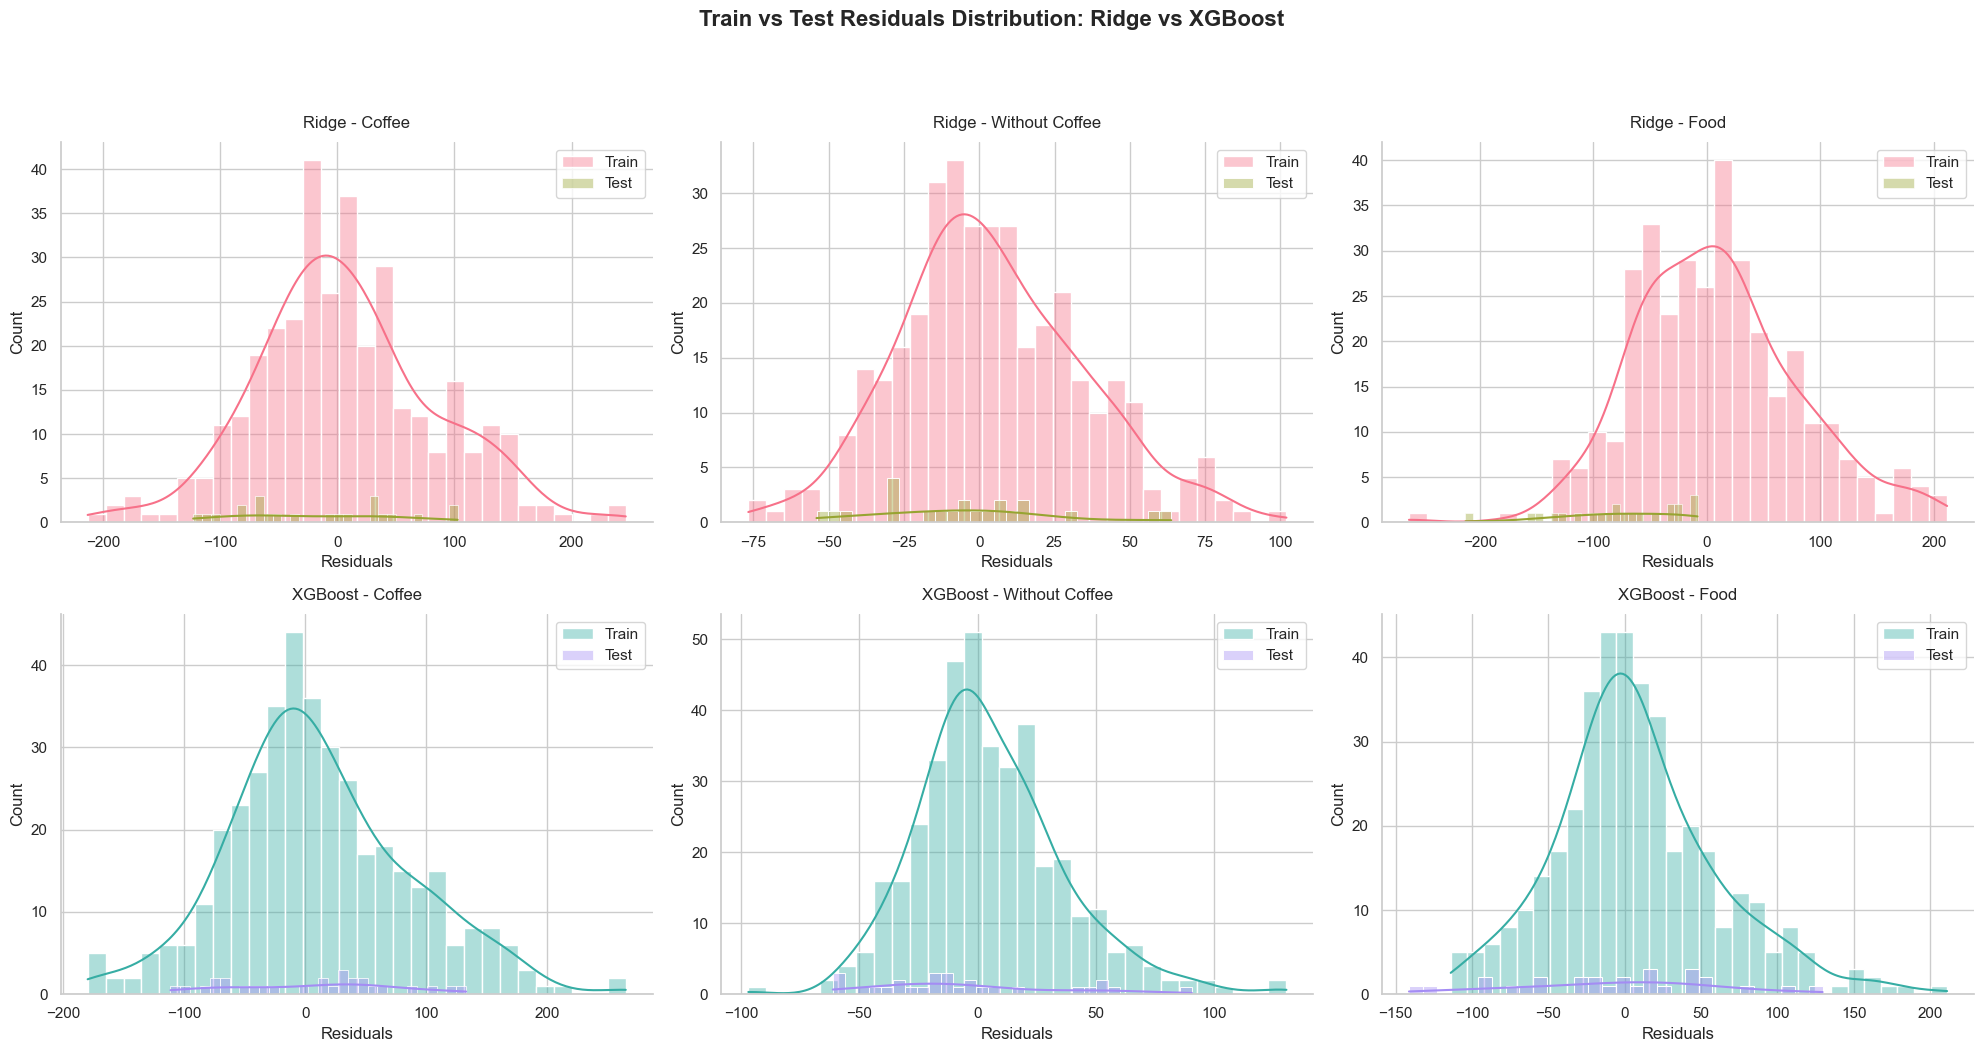

In [658]:
vs.hist_residuals_comparison(residuals_log, residuals_xgb_log, categories)

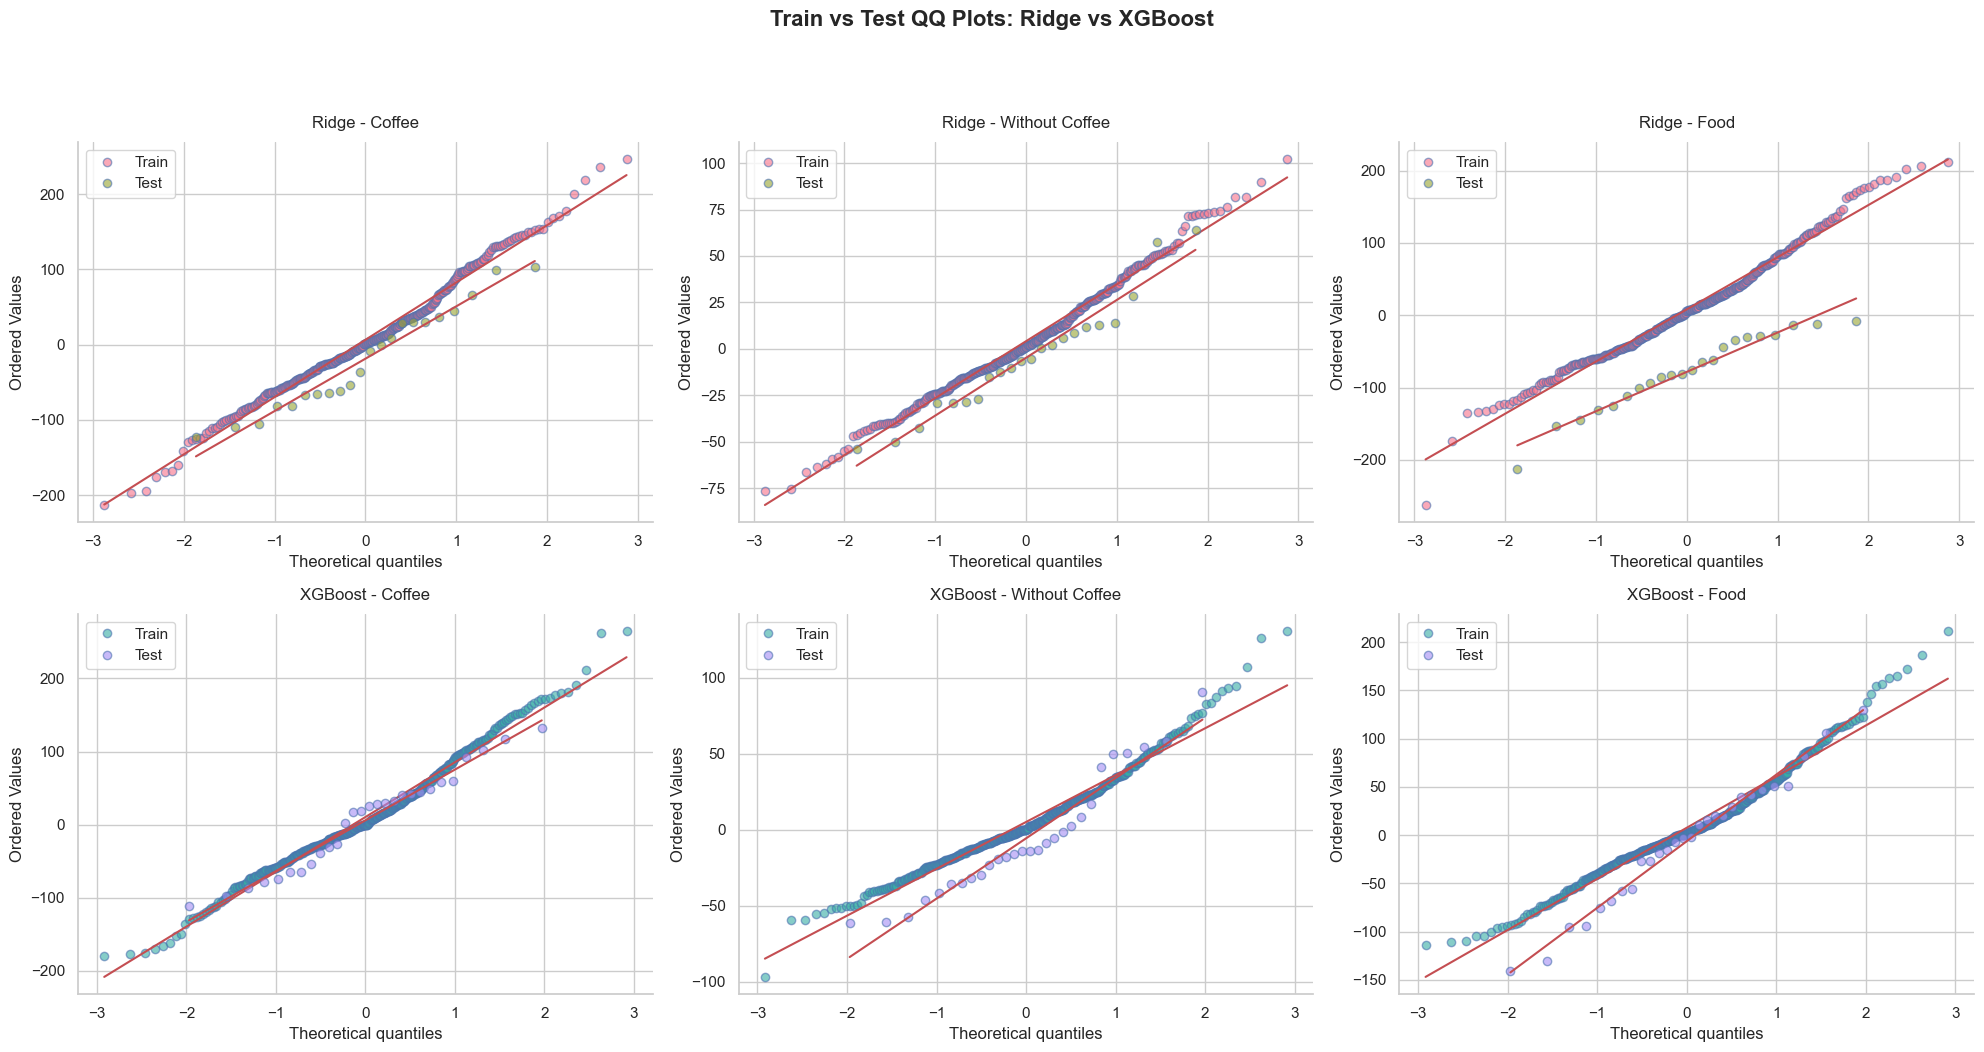

In [659]:
vs.plot_qq_comparison(residuals_log, residuals_xgb_log, categories)

#### Save the models

In [660]:
def save_best_models(model, type, category):
    filename = f"sales_models/{type}_model_{category}.pkl"
    with open(filename, "wb") as f:
        dill.dump(model, f)
    print(f"Saved best model for {category} to {filename}")

In [661]:
save_best_models(xgb_models['Coffee'], 'xgb', 'Coffee')
save_best_models(xgb_models['Without Coffee'], 'xgb', 'Without_Coffee')
save_best_models(xgb_models['Food'], 'xgb', 'Food')

Saved best model for Coffee to sales_models/xgb_model_Coffee.pkl
Saved best model for Without_Coffee to sales_models/xgb_model_Without_Coffee.pkl
Saved best model for Food to sales_models/xgb_model_Food.pkl
